In this code, I want to compare slope constrained and linear spline model. for the former, i will set the same grid which i will use for the latter. thus both the models would be equivalent and ideally should behave the same!

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained
from activations.linearspline import LinearSpline

import os
import json
from tqdm import tqdm

# dataset (2 moons)
from sklearn.datasets import make_moons


import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [2]:
# Function to generate data from a 1D Gaussian distribution
def generate_gaussian_data(mean, 
            std_dev, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Gaussian distribution.

    Parameters:
    - mean: Mean of the Gaussian distribution
    - std_dev: Standard deviation of the Gaussian distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.normal(loc=mean, scale=std_dev, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader





In [3]:
# Function to generate data from a 1D Laplace distribution
def generate_laplace_data(mean, scale, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Laplace distribution.

    Parameters:
    - mean: Mean (location parameter) of the Laplace distribution
    - scale: Scale (diversity) parameter of the Laplace distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.laplace(loc=mean, scale=scale, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data




In [4]:
# GENERATE GAUSSIAN DATA
# mean = 3.0#2
# std_dev = 3.0
# total_samples = 8000#50000

# train_data, val_data, test_data = generate_gaussian_data(mean, std_dev, total_samples)

# GENERATE LAPLACE DATA
mean = 4.5
scale = 6
total_samples = 10000
# for each minibatch, new data
#
train_data, val_data, test_data = generate_laplace_data(mean, scale, total_samples)
print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 7000, Val size: 1500, Test size: 1500


In [5]:
# Reshape data before returning
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Convert to DataLoaders
batch_size = 20#16#32#16#16#32
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 7000
Validation set size: 1500
Test set size: 1500


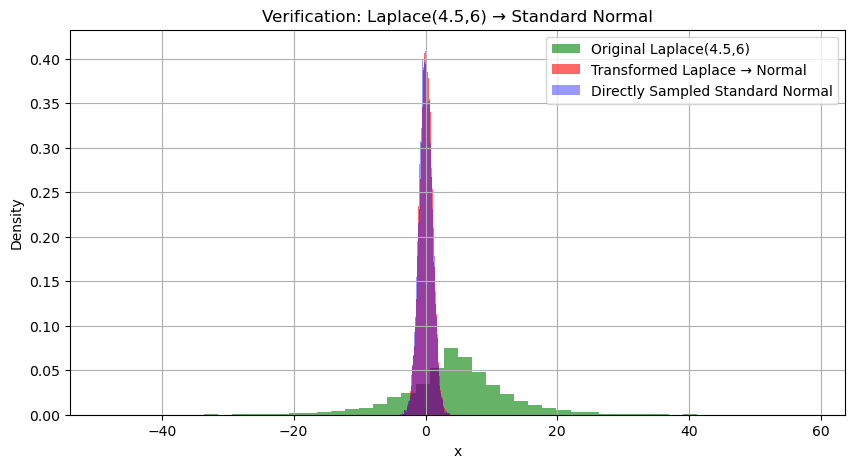

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace

# Transformation function for Laplace(mu, b) → Standard Normal
def laplace_to_normal(x, mu=0, b=1):
    """
    Transforms a Laplace(mu, b) distributed variable into a standard normal.
    
    Args:
    - x: Input Laplace-distributed samples.
    - mu: Mean of the Laplace distribution.
    - b: Scale parameter of the Laplace distribution.
    
    Returns:
    - Transformed values following a standard normal distribution.
    """
    # Compute shifted & scaled Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))
    # Apply inverse CDF of standard normal
    return norm.ppf(F_X)

# Step 1: Sample from a Laplace distribution with custom mean and scale
num_samples = 10000
mu, b = mean, scale  # Example: Laplace(2, 1.5)
laplace_samples = laplace.rvs(loc=mu, scale=b, size=num_samples)

# Step 2: Apply transformation
normal_samples_transformed = laplace_to_normal(laplace_samples, mu, b)

# Step 3: Sample directly from standard normal for comparison
normal_samples_direct = norm.rvs(size=num_samples)

# Step 4: Plot histograms before and after transformation
plt.figure(figsize=(10, 5))

# Original Laplace distribution before transformation
plt.hist(laplace_samples, bins=50, density=True, alpha=0.6, color='g', label=f'Original Laplace({mu},{b})')

# Transformed Laplace samples
plt.hist(normal_samples_transformed, bins=50, density=True, alpha=0.6, color='r', label='Transformed Laplace → Normal')

# Direct Standard Normal samples
plt.hist(normal_samples_direct, bins=50, density=True, alpha=0.4, color='b', label='Directly Sampled Standard Normal')

# Labels and legend
plt.title(f"Verification: Laplace({mu},{b}) → Standard Normal")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


In [7]:
from scipy.stats import norm



def transformation_laplace_to_std_normal(mu=0, b=1, x_range=(-10,10), num_points=41):
    # Define x values
    x = np.linspace(x_range[0], x_range[1], num_points)

    # Compute Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))

    # Compute the transformation function T(x)
    T_x = norm.ppf(F_X)

    return x,T_x

def plot_transformation(mu=0, b=1, x_range=(-5, 5), num_points=1000):
    """
    Plots the transformation function T(x) = Φ⁻¹(F_X(x)) that maps a 
    Laplace(mu, b) distributed variable to a standard normal.
    
    Args:
    - mu: Mean of the Laplace distribution.
    - b: Scale parameter of the Laplace distribution.
    - x_range: Tuple defining the range of x values for the plot.
    - num_points: Number of points in the plot.
    
    Returns:
    - A plot of T(x) = Φ⁻¹(F_X(x)).
    """
    x,T_x = transformation_laplace_to_std_normal(mu=mu, b=b, x_range=x_range, num_points=num_points)

    # Plot T(x)
    plt.figure(figsize=(7, 5))
    plt.plot(x, T_x, label=r'$T(x) = \Phi^{-1}(F_X(x))$', color='b')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel("$x$")
    plt.ylabel("$T(x)$")
    plt.title(f"Transformation Function from Laplace({mu}, {b}) to Standard Normal")
    plt.legend()
    plt.grid(which='both')  # Optional: Add a grid
    plt.minorticks_on()

    # Bold major grid lines
    plt.grid(which='major', linestyle='-', linewidth=1.5, alpha=0.9, color='black')

    # Light minor grid lines
    plt.grid(which='minor', linestyle=':', linewidth=0.7, alpha=0.5, color='gray')
    plt.show()


In [8]:
# Now i need to train this model using NLL loss
def nll_loss(z, det_jacobian, alpha_nll=1,return_indiv_loss=0):
    '''
    z :  tensor z in latent space
    det_jacobian : det(J_{f}(xi)) for each xi (we will take abs in this fn later)
    '''
    loss_1 = 0.5 * torch.sum(z**2)
    # print("det jacobian is:"); print(det_jacobian)
    #loss_2 = torch.sum(torch.log(torch.abs(det_jacobian)))
    loss_2 = torch.sum(torch.log(det_jacobian)) # coy slopes are always positive
    # print("torch.log(torch.abs(det_jacobian):",torch.log(torch.abs(det_jacobian)))
    # print(f"loss 1 is: {loss_1} and loss 2 is: {loss_2}")
    dataset_length = z.size(0)
    loss_with_alpha = (loss_1-loss_2)/ dataset_length # earlier i have some multiplicative alpha here but i removed it as we dont need it
    loss_normal = (loss_1 - loss_2)/ dataset_length
    if return_indiv_loss:
        return loss_with_alpha, loss_normal,loss_1/dataset_length, loss_2/dataset_length
    return loss_with_alpha, loss_normal

In [9]:
def plot_multiple_histogram(list_of_inputs, labels_list):
    # add a code line here: if the inputs are not numpy, convert them to numpy
    plt.figure(figsize=(5, 5))

    for i in range(0,len(list_of_inputs)):
        # Histogram for the code samples
        plt.hist(list_of_inputs[i], bins=50, alpha=0.4, 
                density=True, label=labels_list[i])
        plt.legend()

In [10]:
# plot splines with annotations
def plot_with_annotations(x, y,label="with const coeffs",
                title="Plot with (x, y) Annotations", 
            xlabel="X-axis", ylabel="Y-axis",
            txt_color="red", annotate=1, style="-o"):
    """
    Plot x and y values with (x, y) annotations.

    Args:
    - x (array-like): Array of x-values.
    - y (array-like): Array of y-values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.

    Returns:
    - None
    """
    plt.plot(x, y, style,label=label)  # Plot the points with markers and lines

    # Annotate each point with its (x, y) coordinates
    if annotate:
        for x_val, y_val in zip(x, y):
            plt.annotate(
                f"({x_val:.2f}, {y_val:.2f})",  # Format to 2 decimal places
                (x_val, y_val),  # The point to annotate
                textcoords="offset points",  # Offset the text slightly
                xytext=(5, 5),  # Offset (5, 5) pixels
                fontsize=8,  # Font size of the annotation
                color=txt_color # Optional: text color
            )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(which='both')  # Optional: Add a grid
    plt.minorticks_on()

    # Define x values
    x = np.linspace(-40, 40, 1000)

    # Compute Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))

    # Compute the transformation function T(x)
    T_x = norm.ppf(F_X)

    # Plot T(x)
    plt.plot(x, T_x, label=r'$T(x) = \Phi^{-1}(F_X(x))$', color='b')

    # Bold major grid lines
    plt.grid(which='major', linestyle='-', linewidth=1.5, alpha=0.9, color='black')

    # Light minor grid lines
    plt.grid(which='minor', linestyle=':', linewidth=0.7, alpha=0.5, color='gray')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()

In [11]:
def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.

    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)

    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)

    return tv2[0] 

In [12]:
# train and evaluate fn.
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1,
    alpha_nll=1,
    track_coefficients = False, type_model="ls"#"scls"
):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model: The NF model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR", etc.).
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', or 'ReduceLROnPlateau'.")

    train_losses = []  # List to store training losses
    loss_1_list=[]
    loss_2_list=[]
    val_losses = []  # List to store validation losses
    model_params_history = []  # To store model state_dicts for each epoch
    # Save a copy of the model's state_dict
    model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

    if track_coefficients:
        coeffs_evol=[]
        slope_const_coeffs_evol=[]

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0
        total_train_and_regul_loss=0.0
        total_loss_1=0.0; total_loss_2=0.0

        if track_coefficients:
            # do I really need to change them to numpy?
            coeffs=model.coefficients_vect.detach().numpy()
            if type_model=="ls":  #activations.linearspline_slope_constraint.LinearSplineSlopeConstrained
                slope_const_coeffs = model.lipschitz_coefficients_vect.detach().numpy()
            elif type_model== "scls":
                slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # data is a list containing the tensor [tensor()]
            # print(f"shape of inputs: {inputs.size()}")
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model(inputs)

            # Loss calculation
            ## Normal loss term
            train_loss, loss_normal, loss_1, loss_2 = nll_loss(encoded, model.grad_x_temp,
                                            alpha_nll=alpha_nll,return_indiv_loss=1)

            ### TV2 regularisation term
            if tv2_regulation:
                tv2_regul = TV2(model, model.coefficients_vect.device)
            # print(f"tv2 regul: {tv2_regul}")
            ## Total loss
            if tv2_regulation:
                total_loss = train_loss + lambda_tv2 * tv2_regul
            else:
                total_loss = train_loss
            # print(f"lambda_tv2 {(lambda_tv2 )} x tv2_regul: {lambda_tv2 * tv2_regul}")
            # Backward pass (gradient computation)
            total_loss.backward()

            # Update weights
            optimizer.step()
            total_train_and_regul_loss += total_loss.item()
            total_train_loss += train_loss.item()#loss_normal.item()#train_loss.item()
            total_loss_1 +=loss_1.item()
            total_loss_2 += loss_2.item()# initially this + was missing
        # Step the scheduler
        if scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))
        
        # Save a copy of the model's state_dict
        model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

        # i commented it because i also want to see how coefficients look before the training begins
        # if track_coefficients:
        #     # do I really need to change them to numpy?
        #     coeffs=model.coefficients_vect.detach().numpy()
        #     slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
        #     coeffs_evol.append(list(coeffs))
        #     slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)
        avg_train_and_regul_loss = total_train_and_regul_loss / len(train_loader)
        avg_loss_1 = total_loss_1/len(train_loader)
        avg_loss_2 = total_loss_2/len(train_loader)
        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass (encoding) for validation
                    val_encoded = model(val_inputs)

                    # Loss calculation for validation
                    val_loss,_ = nll_loss(val_encoded, model.grad_x_temp)

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f" train NLL+{lambda_tv2 * int(tv2_regulation)}XTV2: {avg_train_and_regul_loss}, "
                    f"data avg loss-1: {avg_loss_1} ,"
                    f"data avg loss-2: {avg_loss_2} ,"
                    f"Training NLL Loss: {average_train_loss}, "
                    f"Validation NLL Loss: {average_val_loss}, "
                    f"LR: {scheduler.get_last_lr()[0]}"
                )

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses,model_params_history, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses,model_params_history


In [13]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
def plot_coefficients_evolution(num_coeffs, coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs = List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    '''
    # Calculate grid dimensions dynamically
    cols = math.ceil(math.sqrt(num_coeffs))  # Number of columns
    rows = math.ceil(num_coeffs / cols)      # Number of rows
    
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axs = axs.flatten()  # Flatten for easier indexing

    for i in range(num_coeffs):
        ax = axs[i]
        ax.plot(coeffs[:, i], "-o", label=f"coeff[{i}]")
        ax.plot(slope_constr_coeffs[:, i], ":o", label=f"slope constr coeff[{i}]")
        ax.set_title(f"Coefficient {i}")
        ax.set_ylabel("Value")
        if log_scale:
            ax.set_yscale("log")
        ax.legend(loc='upper right')
        ax.grid(True)
    
    # Hide unused subplots
    for i in range(num_coeffs, len(axs)):
        axs[i].axis('off')
    
    # Set x-label for bottom row only
    for i in range(len(axs) - cols, len(axs)):
        axs[i].set_xlabel("Training epochs")
    
    fig.suptitle("Evolution of coefficients with training of a spline", y=1.00)
    plt.tight_layout()
    plt.show()

    


In [15]:
# fn to load weights into model. This fn is used later to visualise the code space during training
# to study training dynammics
def load_weights_into_model(model, parameters_dict):
    """
    Loads weights into the SplineNN model using a state_dict-like dictionary.

    Args:
    - model (SplineNN): The model into which weights are to be loaded.
    - parameters_dict (dict): A dictionary of parameters (state_dict format).
      Keys should match those in the model's state_dict.

    Returns:
    None
    """
    # Ensure the keys match between the input dictionary and the model's state_dict
    model_state_dict = model.state_dict()
    
    # Verify all keys are present in the provided parameters
    for key in model_state_dict.keys():
        if key not in parameters_dict:
            raise ValueError(f"Key '{key}' not found in provided parameters.")

    # Load parameters into the model
    for name, param in model_state_dict.items():
        if name in parameters_dict:
            param.data.copy_(parameters_dict[name])
        else:
            raise ValueError(f"Missing parameter for layer: {name}")

    # print("Weights successfully loaded into the model.")

In [16]:
# Visualize the training dynamics in the code space using histograms
def plot_multiple_z_with_normal_1d(models_params, test_data, model, 
                                   num_samples=1000, mean=0, 
                                   std=1, figsize=(10, 10), bins=50,
                                   print_model_params=0, plot_frequency=1):
    """
    Plots multiple 1D histograms of z and 1D normal distribution samples in a grid.

    Args:
    - models_params (list): List of model parameters for each epoch (including initial params).
    - test_data (numpy.ndarray): Test data for encoding.
    - model (torch.nn.Module): The neural network model.
    - num_samples (int): Number of points to sample from the 1D normal distribution.
    - mean (float): Mean of the 1D normal distribution.
    - std (float): Standard deviation of the 1D normal distribution.
    - figsize (tuple): Size of the overall figure.
    - bins (int): Number of bins for the histograms.
    - print_model_params (int): Whether to print model parameters (0 or 1).
    - plot_frequency (int): Frequency of plotting histograms (e.g., every 5 epochs).

    Returns:
    None
    """
    # Filter epochs to plot based on frequency
    epochs_to_plot = [i for i in range(len(models_params)) if i % plot_frequency == 0 or i == 0]
    num_plots = len(epochs_to_plot)
    
    # Prepare the normal distribution samples
    normal_samples = np.random.normal(mean, std, num_samples)
    
    # Create a grid of subplots
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to easily iterate over
    
    test_tensor = torch.tensor(test_data, dtype=torch.float)

    for plot_idx, epoch_idx in enumerate(epochs_to_plot):
        ax = axes[plot_idx]
        
        # Load model weights for the current epoch
        load_weights_into_model(model, models_params[epoch_idx])

        if print_model_params:
            #print(models_params[epoch_idx])
            print(f"slopes: constrrained coeffs: {model.slopes_tensor(for_projected_coeffs=1).detach()}")
        
        # Encode the test data
        with torch.no_grad():
            encoded_test1 = model(test_tensor)
        
        # Plot histogram on the subplot
        ax.hist(normal_samples, bins=bins, color='blue', alpha=0.3, label="Normal Samples", density=True)
        ax.hist(encoded_test1.squeeze().numpy(), bins=bins, color='red', alpha=0.3, label="Encoded z", density=True)
        
        # Set title
        if epoch_idx == 0:
            ax.set_title("Before Training")
        else:
            ax.set_title(f"Epoch {epoch_idx}")  # Show actual epoch number
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")
        ax.grid(True)
    
    # Hide unused subplots
    for ax in axes[num_plots:]:
        ax.axis("off")
    
    # Add a common legend outside the grid
    handles = [
        plt.Line2D([0], [0], color='blue', lw=4, alpha=0.3, label="Normal Samples"),
        plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label="Encoded z")
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=10)
    
    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the legend at the top
    plt.show()


In [17]:
def generate_unequally_spaced_sorted_numbers(start_val, end_val, N):
    """
    Generate N unequally spaced but sorted numbers between start_val and end_val.

    Parameters:
        start_val (float): The starting value of the range.
        end_val (float): The ending value of the range.
        N (int): Number of numbers to generate.

    Returns:
        torch.Tensor: A tensor of N sorted, unequally spaced numbers.
    """
    assert N > 1, "N must be greater than 1 to create a range."
    assert start_val < end_val, "start_val must be less than end_val."
    
    # Generate N random values between 0 and 1
    random_values = torch.rand(N)
    
    # Sort the random values to ensure monotonicity
    sorted_values = torch.sort(random_values).values
    
    # Scale and shift the values to fit into the range [start_val, end_val]
    scaled_values = start_val + (end_val - start_val) * sorted_values
    
    return scaled_values


/home/neel/Desktop/Lipschitz_DSNN/activations/linearspline_slope_constraint.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


initial nodal_val_locs: tensor([[-20.0000, -19.8667, -19.7333, -19.6000, -19.4667, -19.3333, -19.2000,
         -19.0667, -18.9333, -18.8000, -18.6667, -18.5333, -18.4000, -18.2667,
         -18.1333, -18.0000, -17.8667, -17.7333, -17.6000, -17.4667, -17.3333,
         -17.2000, -17.0667, -16.9333, -16.8000, -16.6667, -16.5333, -16.4000,
         -16.2667, -16.1333, -16.0000, -15.8667, -15.7333, -15.6000, -15.4667,
         -15.3333, -15.2000, -15.0667, -14.9333, -14.8000, -14.6667, -14.5333,
         -14.4000, -14.2667, -14.1333, -14.0000, -13.8667, -13.7333, -13.6000,
         -13.4667, -13.3333, -13.2000, -13.0667, -12.9333, -12.8000, -12.6667,
         -12.5333, -12.4000, -12.2667, -12.1333, -12.0000, -11.8667, -11.7333,
         -11.6000, -11.4667, -11.3333, -11.2000, -11.0667, -10.9333, -10.8000,
         -10.6667, -10.5333, -10.4000, -10.2667, -10.1333, -10.0000,  -9.8667,
          -9.7333,  -9.6000,  -9.4667,  -9.3333,  -9.2000,  -9.0667,  -8.9333,
          -8.8000,  -8.6667,

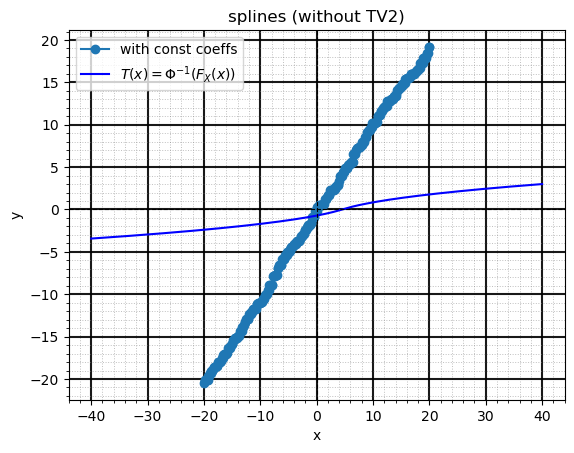

In [18]:
SIZE=301;RANGE=20; START_VAL=-2; END_VAL=10
#GRID_VALS= generate_unequally_spaced_sorted_numbers(start_val=START_VAL,end_val=END_VAL,N=SIZE)
GRID_VALS,FN_INIT = transformation_laplace_to_std_normal(mu=mean, b=scale, x_range=(-RANGE,RANGE), num_points=SIZE)
noise = torch.randn_like(torch.tensor(FN_INIT)) * 2e-1
model2 = LinearSplineSlopeConstrained(
                mode='fc',
                num_activations=1,
                size=SIZE,# number of knots is size -2
                range_=RANGE,
                grid_values=torch.tensor(GRID_VALS),
                # grid_values=torch.tensor([-2.9132, -1.,  1.8,  2.1882,  2.9779]),
                init="manual",#"maxmin",# what if I try relu activation function?
                smin=0.001,
                smax=10,
                slope_constrained=1,
                manual_init_fn_tensor=torch.tensor(FN_INIT)+noise
) 
print("constrained coefficients are: ",model2.slope_constrained_coefficients_vect)
print(f"slopes: constrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
# visualise the code space before the training
input_tensor = torch.tensor(train_data)
output_tensor2=model2(input_tensor)
# plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
#                         ],
#                         labels_list=["data_space (x)","code_space(z)"])

x2pos, y2pos = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()
print('grid vals and x2pos vals')
print(GRID_VALS, x2pos)
print('fn val and slope constrained fn val')
print(FN_INIT, y2pos)
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
plt.figure()
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y",
                    annotate=0, style='-o')
plt.legend()
plt.show()

In [19]:
with torch.no_grad():
   zz,gg=model2(torch.tensor([[-30.], [-20], [0.], [20], [30]])), model2.grad_x_temp
zz,gg, zz**2

(tensor([[-43.0922],
         [-20.4645],
         [ -0.1766],
         [ 19.1847],
         [ 19.1947]], dtype=torch.float64),
 tensor([[2.2628e+00, 2.2628e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03]],
        dtype=torch.float64),
 tensor([[1.8569e+03],
         [4.1879e+02],
         [3.1187e-02],
         [3.6805e+02],
         [3.6844e+02]], dtype=torch.float64))

In [20]:
# training 100 rounds with low tv2 regularization
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=100, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.000095,#0.004
    print_after=1,   
    track_coefficients=1, #
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.001,#0.095, 
    gamma = 0.5, # schedular, learning rate decay factor
    alpha_nll=1# We don;t need any alpha anymore! get rid of this in the code later
) # why is it no # good thing is that it is shifting but the bad thing is that its kind of collapsing to 0 . NOT ANYMORE

Training Progress:   1%|          | 1/100 [00:09<15:16,  9.26s/it]

Epoch 1/100,  train NLL+0.001XTV2: 44.27155423147748, data avg loss-1: 39.970018599613475 ,data avg loss-2: -3.7825250960448282 ,Training NLL Loss: 43.75254369565829, Validation NLL Loss: 36.229923227000555, LR: 9.5e-05


Training Progress:   2%|▏         | 2/100 [00:18<15:14,  9.33s/it]

Epoch 2/100,  train NLL+0.001XTV2: 40.517778535973434, data avg loss-1: 36.12896798681175 ,data avg loss-2: -3.897743311648256 ,Training NLL Loss: 40.02671129846003, Validation NLL Loss: 33.391533806269635, LR: 9.5e-05


Training Progress:   3%|▎         | 3/100 [00:28<15:07,  9.35s/it]

Epoch 3/100,  train NLL+0.001XTV2: 37.774986548532354, data avg loss-1: 33.39559058213633 ,data avg loss-2: -3.9091067875648204 ,Training NLL Loss: 37.304697369701124, Validation NLL Loss: 30.995663988232355, LR: 9.5e-05


Training Progress:   4%|▍         | 4/100 [00:37<14:51,  9.29s/it]

Epoch 4/100,  train NLL+0.001XTV2: 35.248015198557766, data avg loss-1: 30.835431223649216 ,data avg loss-2: -3.96325819395484 ,Training NLL Loss: 34.79868941760408, Validation NLL Loss: 28.72490844014388, LR: 9.5e-05


Training Progress:   5%|▌         | 5/100 [00:46<14:50,  9.37s/it]

Epoch 5/100,  train NLL+0.001XTV2: 32.89620891074391, data avg loss-1: 28.479156200385578 ,data avg loss-2: -3.9876505575475343 ,Training NLL Loss: 32.46680675793313, Validation NLL Loss: 26.892435574223896, LR: 9.5e-05


Training Progress:   6%|▌         | 6/100 [00:55<14:36,  9.32s/it]

Epoch 6/100,  train NLL+0.001XTV2: 30.918553304647624, data avg loss-1: 26.48566860809356 ,data avg loss-2: -4.020559712310126 ,Training NLL Loss: 30.506228320403686, Validation NLL Loss: 25.19181937779929, LR: 9.5e-05


Training Progress:   7%|▋         | 7/100 [01:05<14:21,  9.26s/it]

Epoch 7/100,  train NLL+0.001XTV2: 29.24713389502649, data avg loss-1: 24.794690020353073 ,data avg loss-2: -4.055351440420417 ,Training NLL Loss: 28.85004146077348, Validation NLL Loss: 23.890789254010585, LR: 9.5e-05


Training Progress:   8%|▊         | 8/100 [01:14<14:10,  9.24s/it]

Epoch 8/100,  train NLL+0.001XTV2: 27.82012973189171, data avg loss-1: 23.358284777227794 ,data avg loss-2: -4.078648197398418 ,Training NLL Loss: 27.4369329746262, Validation NLL Loss: 22.70335398181198, LR: 9.5e-05


Training Progress:   9%|▉         | 9/100 [01:23<14:01,  9.25s/it]

Epoch 9/100,  train NLL+0.001XTV2: 26.602883280315627, data avg loss-1: 22.162376310011155 ,data avg loss-2: -4.069647039363405 ,Training NLL Loss: 26.232023349374586, Validation NLL Loss: 21.59164123555664, LR: 9.5e-05


Training Progress:  10%|█         | 10/100 [01:32<13:50,  9.22s/it]

Epoch 10/100,  train NLL+0.001XTV2: 25.388573842794067, data avg loss-1: 21.000852314346652 ,data avg loss-2: -4.029453332034898 ,Training NLL Loss: 25.03030564638157, Validation NLL Loss: 20.71867200273307, LR: 9.5e-05


Training Progress:  11%|█         | 11/100 [01:42<13:44,  9.26s/it]

Epoch 11/100,  train NLL+0.001XTV2: 24.34606962237782, data avg loss-1: 19.979629913774524 ,data avg loss-2: -4.019612475084419 ,Training NLL Loss: 23.999242388858946, Validation NLL Loss: 19.743030604481678, LR: 9.5e-05


Training Progress:  12%|█▏        | 12/100 [01:51<13:30,  9.21s/it]

Epoch 12/100,  train NLL+0.001XTV2: 23.283099469250022, data avg loss-1: 18.97124294804592 ,data avg loss-2: -3.9769635231217784 ,Training NLL Loss: 22.948206471167722, Validation NLL Loss: 18.772449414808122, LR: 9.5e-05


Training Progress:  13%|█▎        | 13/100 [02:00<13:23,  9.23s/it]

Epoch 13/100,  train NLL+0.001XTV2: 22.312300305915837, data avg loss-1: 18.00718327637278 ,data avg loss-2: -3.981654833720901 ,Training NLL Loss: 21.988838110093667, Validation NLL Loss: 18.14749288758209, LR: 9.5e-05


Training Progress:  14%|█▍        | 14/100 [02:09<13:06,  9.15s/it]

Epoch 14/100,  train NLL+0.001XTV2: 21.61240200139744, data avg loss-1: 17.332399750082562 ,data avg loss-2: -3.965737699402856 ,Training NLL Loss: 21.29813744948541, Validation NLL Loss: 17.551108978584725, LR: 9.5e-05


Training Progress:  15%|█▌        | 15/100 [02:18<12:56,  9.14s/it]

Epoch 15/100,  train NLL+0.001XTV2: 20.816832128557596, data avg loss-1: 16.563878042229824 ,data avg loss-2: -3.949181441842019 ,Training NLL Loss: 20.513059484071853, Validation NLL Loss: 16.837259824259874, LR: 9.5e-05


Training Progress:  16%|█▌        | 16/100 [02:27<12:52,  9.19s/it]

Epoch 16/100,  train NLL+0.001XTV2: 20.127348983833265, data avg loss-1: 15.881431602555292 ,data avg loss-2: -3.9521935926759633 ,Training NLL Loss: 19.83362519523125, Validation NLL Loss: 16.278922485428012, LR: 9.5e-05


Training Progress:  17%|█▋        | 17/100 [02:37<12:44,  9.21s/it]

Epoch 17/100,  train NLL+0.001XTV2: 19.576791465872976, data avg loss-1: 15.288285476584596 ,data avg loss-2: -4.003923419774383 ,Training NLL Loss: 19.29220889635897, Validation NLL Loss: 15.859793890983491, LR: 9.5e-05


Training Progress:  18%|█▊        | 18/100 [02:46<12:36,  9.23s/it]

Epoch 18/100,  train NLL+0.001XTV2: 19.009661325440337, data avg loss-1: 14.731321123547174 ,data avg loss-2: -4.002987318894847 ,Training NLL Loss: 18.734308442442007, Validation NLL Loss: 15.277585463818298, LR: 9.5e-05


Training Progress:  19%|█▉        | 19/100 [02:55<12:26,  9.22s/it]

Epoch 19/100,  train NLL+0.001XTV2: 18.403257856975323, data avg loss-1: 14.173819061962345 ,data avg loss-2: -3.9632553262283605 ,Training NLL Loss: 18.137074388190715, Validation NLL Loss: 14.832703181385384, LR: 9.5e-05


Training Progress:  20%|██        | 20/100 [03:04<12:18,  9.23s/it]

Epoch 20/100,  train NLL+0.001XTV2: 17.843953872526644, data avg loss-1: 13.591860605434457 ,data avg loss-2: -3.9959978060131385 ,Training NLL Loss: 17.587858411447595, Validation NLL Loss: 14.253200765494967, LR: 9.5e-05


Training Progress:  21%|██        | 21/100 [03:13<12:06,  9.20s/it]

Epoch 21/100,  train NLL+0.001XTV2: 17.15523440702857, data avg loss-1: 12.929033571134587 ,data avg loss-2: -3.9808121110900583 ,Training NLL Loss: 16.909845682224642, Validation NLL Loss: 13.755283735412972, LR: 9.5e-05


Training Progress:  22%|██▏       | 22/100 [03:23<12:04,  9.29s/it]

Epoch 22/100,  train NLL+0.001XTV2: 16.598966678250022, data avg loss-1: 12.413649181952078 ,data avg loss-2: -3.948504052015631 ,Training NLL Loss: 16.362153233967696, Validation NLL Loss: 13.280076694814811, LR: 9.5e-05


Training Progress:  23%|██▎       | 23/100 [03:32<11:53,  9.27s/it]

Epoch 23/100,  train NLL+0.001XTV2: 16.091072503223774, data avg loss-1: 11.931622375137925 ,data avg loss-2: -3.930274052286743 ,Training NLL Loss: 15.861896427424652, Validation NLL Loss: 12.894806331200927, LR: 9.5e-05


Training Progress:  24%|██▍       | 24/100 [03:42<11:48,  9.32s/it]

Epoch 24/100,  train NLL+0.001XTV2: 15.587242744169837, data avg loss-1: 11.402545146624718 ,data avg loss-2: -3.96350889913414 ,Training NLL Loss: 15.36605404575885, Validation NLL Loss: 12.535341767940263, LR: 9.5e-05


Training Progress:  25%|██▌       | 25/100 [03:51<11:45,  9.41s/it]

Epoch 25/100,  train NLL+0.001XTV2: 15.12787197251712, data avg loss-1: 10.946891726014023 ,data avg loss-2: -3.967565301581882 ,Training NLL Loss: 14.914457027595898, Validation NLL Loss: 12.080498183235854, LR: 9.5e-05


Training Progress:  26%|██▌       | 26/100 [04:01<11:38,  9.44s/it]

Epoch 26/100,  train NLL+0.001XTV2: 14.740009093255656, data avg loss-1: 10.591244418020677 ,data avg loss-2: -3.9420952404576313 ,Training NLL Loss: 14.533339658478324, Validation NLL Loss: 11.792978976284436, LR: 9.5e-05


Training Progress:  27%|██▋       | 27/100 [04:10<11:24,  9.38s/it]

Epoch 27/100,  train NLL+0.001XTV2: 14.355019361658126, data avg loss-1: 10.178951323197113 ,data avg loss-2: -3.9755467577806174 ,Training NLL Loss: 14.154498080977742, Validation NLL Loss: 11.610495873201414, LR: 9.5e-05


Training Progress:  28%|██▊       | 28/100 [04:19<11:17,  9.41s/it]

Epoch 28/100,  train NLL+0.001XTV2: 14.017791371930016, data avg loss-1: 9.859066880210298 ,data avg loss-2: -3.963635514672356 ,Training NLL Loss: 13.822702394882644, Validation NLL Loss: 11.23867880490881, LR: 9.5e-05


Training Progress:  29%|██▉       | 29/100 [04:29<11:09,  9.42s/it]

Epoch 29/100,  train NLL+0.001XTV2: 13.553522807261121, data avg loss-1: 9.374085405284774 ,data avg loss-2: -3.9924459110843533 ,Training NLL Loss: 13.366531316369125, Validation NLL Loss: 10.880303222760926, LR: 9.5e-05


Training Progress:  30%|███       | 30/100 [04:38<10:59,  9.42s/it]

Epoch 30/100,  train NLL+0.001XTV2: 13.315782695167064, data avg loss-1: 9.136333011711631 ,data avg loss-2: -3.9979025216038337 ,Training NLL Loss: 13.134235533315454, Validation NLL Loss: 10.708325001715622, LR: 9.5e-05


Training Progress:  31%|███       | 31/100 [04:47<10:40,  9.29s/it]

Epoch 31/100,  train NLL+0.001XTV2: 13.05652872567484, data avg loss-1: 8.91447730375402 ,data avg loss-2: -3.9661801150927176 ,Training NLL Loss: 12.880657418846749, Validation NLL Loss: 10.449754592792548, LR: 9.5e-05


Training Progress:  32%|███▏      | 32/100 [04:57<10:31,  9.29s/it]

Epoch 32/100,  train NLL+0.001XTV2: 12.701540872460447, data avg loss-1: 8.623946162225442 ,data avg loss-2: -3.908308369759936 ,Training NLL Loss: 12.532254531985364, Validation NLL Loss: 10.008264706896773, LR: 9.5e-05


Training Progress:  33%|███▎      | 33/100 [05:06<10:20,  9.26s/it]

Epoch 33/100,  train NLL+0.001XTV2: 12.199131209275734, data avg loss-1: 8.174011110554124 ,data avg loss-2: -3.863359578936061 ,Training NLL Loss: 12.037370689490196, Validation NLL Loss: 9.705340990847272, LR: 9.5e-05


Training Progress:  34%|███▍      | 34/100 [05:15<10:05,  9.18s/it]

Epoch 34/100,  train NLL+0.001XTV2: 11.890457561540458, data avg loss-1: 7.885380426750509 ,data avg loss-2: -3.8489217131412548 ,Training NLL Loss: 11.734302139891755, Validation NLL Loss: 9.420959559511246, LR: 9.5e-05


Training Progress:  35%|███▌      | 35/100 [05:24<09:55,  9.17s/it]

Epoch 35/100,  train NLL+0.001XTV2: 11.53772630540562, data avg loss-1: 7.573093962591689 ,data avg loss-2: -3.8150804609215934 ,Training NLL Loss: 11.388174423513279, Validation NLL Loss: 9.145293773170941, LR: 9.5e-05


Training Progress:  36%|███▌      | 36/100 [05:33<09:51,  9.25s/it]

Epoch 36/100,  train NLL+0.001XTV2: 11.146162854983272, data avg loss-1: 7.228271025683864 ,data avg loss-2: -3.7756015891989723 ,Training NLL Loss: 11.003872614882821, Validation NLL Loss: 8.775402792673852, LR: 9.5e-05


Training Progress:  37%|███▋      | 37/100 [05:43<09:41,  9.23s/it]

Epoch 37/100,  train NLL+0.001XTV2: 10.84017401529208, data avg loss-1: 6.935604762807017 ,data avg loss-2: -3.768408533005225 ,Training NLL Loss: 10.704013295812246, Validation NLL Loss: 8.624335884249962, LR: 9.5e-05


Training Progress:  38%|███▊      | 38/100 [05:52<09:33,  9.25s/it]

Epoch 38/100,  train NLL+0.001XTV2: 10.606206070518192, data avg loss-1: 6.743809695412014 ,data avg loss-2: -3.731671952046786 ,Training NLL Loss: 10.475481647458794, Validation NLL Loss: 8.31978343671812, LR: 9.5e-05


Training Progress:  39%|███▉      | 39/100 [06:01<09:24,  9.25s/it]

Epoch 39/100,  train NLL+0.001XTV2: 10.249024660575039, data avg loss-1: 6.39537780562879 ,data avg loss-2: -3.72969471779958 ,Training NLL Loss: 10.125072523428363, Validation NLL Loss: 8.185009927212151, LR: 9.5e-05


Training Progress:  40%|████      | 40/100 [06:10<09:17,  9.29s/it]

Epoch 40/100,  train NLL+0.001XTV2: 9.980989764585475, data avg loss-1: 6.097643749618588 ,data avg loss-2: -3.765946188746785 ,Training NLL Loss: 9.863589938365372, Validation NLL Loss: 8.002606662623249, LR: 9.5e-05


Training Progress:  41%|████      | 41/100 [06:20<09:12,  9.36s/it]

Epoch 41/100,  train NLL+0.001XTV2: 9.80096385105737, data avg loss-1: 5.887995822881089 ,data avg loss-2: -3.8010105969535632 ,Training NLL Loss: 9.689006419834659, Validation NLL Loss: 7.820017419836046, LR: 9.5e-05


Training Progress:  42%|████▏     | 42/100 [06:30<09:11,  9.50s/it]

Epoch 42/100,  train NLL+0.001XTV2: 9.54908473443716, data avg loss-1: 5.70110175943787 ,data avg loss-2: -3.7406596296063475 ,Training NLL Loss: 9.441761389044217, Validation NLL Loss: 7.5919045746853016, LR: 9.5e-05


Training Progress:  43%|████▎     | 43/100 [06:40<09:07,  9.61s/it]

Epoch 43/100,  train NLL+0.001XTV2: 9.317553162028972, data avg loss-1: 5.432095802392872 ,data avg loss-2: -3.783571801844083 ,Training NLL Loss: 9.215667604236955, Validation NLL Loss: 7.503761593026568, LR: 9.5e-05


Training Progress:  44%|████▍     | 44/100 [06:49<08:55,  9.56s/it]

Epoch 44/100,  train NLL+0.001XTV2: 9.139787765429531, data avg loss-1: 5.274926477771977 ,data avg loss-2: -3.7676226199651066 ,Training NLL Loss: 9.042549097737073, Validation NLL Loss: 7.293168095000291, LR: 9.5e-05


Training Progress:  45%|████▌     | 45/100 [06:59<08:42,  9.51s/it]

Epoch 45/100,  train NLL+0.001XTV2: 8.955347361949496, data avg loss-1: 5.103104098387778 ,data avg loss-2: -3.759261627122673 ,Training NLL Loss: 8.862365725510445, Validation NLL Loss: 7.12777518347099, LR: 9.5e-05


Training Progress:  46%|████▌     | 46/100 [07:08<08:31,  9.48s/it]

Epoch 46/100,  train NLL+0.001XTV2: 8.819290156151178, data avg loss-1: 4.960648425735879 ,data avg loss-2: -3.769688427359191 ,Training NLL Loss: 8.730336853095075, Validation NLL Loss: 7.043716741548254, LR: 9.5e-05


Training Progress:  47%|████▋     | 47/100 [07:17<08:18,  9.41s/it]

Epoch 47/100,  train NLL+0.001XTV2: 8.590192209675157, data avg loss-1: 4.798372672756255 ,data avg loss-2: -3.7067659140898424 ,Training NLL Loss: 8.505138586846096, Validation NLL Loss: 6.885065056260995, LR: 9.5e-05


Training Progress:  48%|████▊     | 48/100 [07:27<08:09,  9.42s/it]

Epoch 48/100,  train NLL+0.001XTV2: 8.363454975934623, data avg loss-1: 4.6399472269360755 ,data avg loss-2: -3.642382785898079 ,Training NLL Loss: 8.282330012834159, Validation NLL Loss: 6.799812624978543, LR: 9.5e-05


Training Progress:  49%|████▉     | 49/100 [07:36<07:58,  9.39s/it]

Epoch 49/100,  train NLL+0.001XTV2: 8.22364719933066, data avg loss-1: 4.466263280877475 ,data avg loss-2: -3.6797947875193917 ,Training NLL Loss: 8.146058068396865, Validation NLL Loss: 6.577123106571889, LR: 9.5e-05


Training Progress:  50%|█████     | 50/100 [07:45<07:48,  9.37s/it]

Epoch 50/100,  train NLL+0.001XTV2: 8.026826751606647, data avg loss-1: 4.333955981322109 ,data avg loss-2: -3.618165422248425 ,Training NLL Loss: 7.95212140357053, Validation NLL Loss: 6.4605380522284035, LR: 9.5e-05


Training Progress:  51%|█████     | 51/100 [07:55<07:41,  9.42s/it]

Epoch 51/100,  train NLL+0.001XTV2: 7.863277485128561, data avg loss-1: 4.164825197570714 ,data avg loss-2: -3.626583371659388 ,Training NLL Loss: 7.791408569230102, Validation NLL Loss: 6.362804221397803, LR: 9.5e-05


Training Progress:  52%|█████▏    | 52/100 [08:04<07:32,  9.43s/it]

Epoch 52/100,  train NLL+0.001XTV2: 7.769057909536081, data avg loss-1: 4.067839145152075 ,data avg loss-2: -3.6320181012644603 ,Training NLL Loss: 7.699857246416527, Validation NLL Loss: 6.213104347761975, LR: 9.5e-05


Training Progress:  53%|█████▎    | 53/100 [08:14<07:23,  9.44s/it]

Epoch 53/100,  train NLL+0.001XTV2: 7.614490735232881, data avg loss-1: 3.963180438932015 ,data avg loss-2: -3.58470132728512 ,Training NLL Loss: 7.547881766217148, Validation NLL Loss: 6.137636105848391, LR: 9.5e-05


Training Progress:  54%|█████▍    | 54/100 [08:23<07:15,  9.47s/it]

Epoch 54/100,  train NLL+0.001XTV2: 7.514830352863563, data avg loss-1: 3.8573206935666717 ,data avg loss-2: -3.5934479257487557 ,Training NLL Loss: 7.450768619315433, Validation NLL Loss: 5.978769124469138, LR: 9.5e-05


Training Progress:  55%|█████▌    | 55/100 [08:33<07:05,  9.46s/it]

Epoch 55/100,  train NLL+0.001XTV2: 7.383607235970562, data avg loss-1: 3.775883044111089 ,data avg loss-2: -3.5461875502915263 ,Training NLL Loss: 7.322070594402617, Validation NLL Loss: 5.905136602969488, LR: 9.5e-05


Training Progress:  56%|█████▌    | 56/100 [08:42<06:57,  9.49s/it]

Epoch 56/100,  train NLL+0.001XTV2: 7.298448097266754, data avg loss-1: 3.716421424694504 ,data avg loss-2: -3.5228039358836525 ,Training NLL Loss: 7.239225360578157, Validation NLL Loss: 5.849616713348694, LR: 9.5e-05


Training Progress:  57%|█████▋    | 57/100 [08:51<06:43,  9.37s/it]

Epoch 57/100,  train NLL+0.001XTV2: 7.184377939751419, data avg loss-1: 3.628760490873244 ,data avg loss-2: -3.49894946420735 ,Training NLL Loss: 7.127709955080594, Validation NLL Loss: 5.787257646858799, LR: 9.5e-05


Training Progress:  58%|█████▊    | 58/100 [09:00<06:28,  9.25s/it]

Epoch 58/100,  train NLL+0.001XTV2: 7.023805618634115, data avg loss-1: 3.488948997861385 ,data avg loss-2: -3.480973639798072 ,Training NLL Loss: 6.969922637659457, Validation NLL Loss: 5.583452513848238, LR: 9.5e-05


Training Progress:  59%|█████▉    | 59/100 [09:10<06:21,  9.31s/it]

Epoch 59/100,  train NLL+0.001XTV2: 6.87886792164007, data avg loss-1: 3.3472249411360324 ,data avg loss-2: -3.4802927798807657 ,Training NLL Loss: 6.827517721016796, Validation NLL Loss: 5.556826488158858, LR: 9.5e-05


Training Progress:  60%|██████    | 60/100 [09:19<06:13,  9.34s/it]

Epoch 60/100,  train NLL+0.001XTV2: 6.770854184587232, data avg loss-1: 3.232056782033674 ,data avg loss-2: -3.4897116792215637 ,Training NLL Loss: 6.721768461255237, Validation NLL Loss: 5.500861873357696, LR: 9.5e-05


Training Progress:  61%|██████    | 61/100 [09:28<06:04,  9.33s/it]

Epoch 61/100,  train NLL+0.001XTV2: 6.650422620803534, data avg loss-1: 3.1425438640656527 ,data avg loss-2: -3.4604704525979035 ,Training NLL Loss: 6.603014316663561, Validation NLL Loss: 5.350729942824395, LR: 9.5e-05


Training Progress:  62%|██████▏   | 62/100 [09:38<05:52,  9.28s/it]

Epoch 62/100,  train NLL+0.001XTV2: 6.561361576825144, data avg loss-1: 3.061616542036859 ,data avg loss-2: -3.4540270496265744 ,Training NLL Loss: 6.515643591663432, Validation NLL Loss: 5.364760404507331, LR: 9.5e-05


Training Progress:  63%|██████▎   | 63/100 [09:47<05:44,  9.30s/it]

Epoch 63/100,  train NLL+0.001XTV2: 6.449881972522289, data avg loss-1: 2.9923989743842547 ,data avg loss-2: -3.4132734515528615 ,Training NLL Loss: 6.405672425937121, Validation NLL Loss: 5.218088732110338, LR: 9.5e-05


Training Progress:  64%|██████▍   | 64/100 [09:57<05:37,  9.37s/it]

Epoch 64/100,  train NLL+0.001XTV2: 6.345034194038497, data avg loss-1: 2.91469084107367 ,data avg loss-2: -3.3873906281099693 ,Training NLL Loss: 6.302081469183636, Validation NLL Loss: 5.108815827377888, LR: 9.5e-05


Training Progress:  65%|██████▌   | 65/100 [10:06<05:24,  9.28s/it]

Epoch 65/100,  train NLL+0.001XTV2: 6.28033017691742, data avg loss-1: 2.885497928447947 ,data avg loss-2: -3.352926911674364 ,Training NLL Loss: 6.2384248401223115, Validation NLL Loss: 5.078754211616766, LR: 9.5e-05


Training Progress:  66%|██████▌   | 66/100 [10:15<05:13,  9.21s/it]

Epoch 66/100,  train NLL+0.001XTV2: 6.203909065185362, data avg loss-1: 2.8252960903379223 ,data avg loss-2: -3.337919967618809 ,Training NLL Loss: 6.163216057956732, Validation NLL Loss: 5.071429523618416, LR: 9.5e-05


Training Progress:  67%|██████▋   | 67/100 [10:24<05:03,  9.21s/it]

Epoch 67/100,  train NLL+0.001XTV2: 6.082537191609367, data avg loss-1: 2.7028697761741807 ,data avg loss-2: -3.340732211765861 ,Training NLL Loss: 6.04360198794004, Validation NLL Loss: 4.946986812981236, LR: 9.5e-05


Training Progress:  68%|██████▊   | 68/100 [10:33<04:53,  9.18s/it]

Epoch 68/100,  train NLL+0.001XTV2: 5.98727198035294, data avg loss-1: 2.5846780736341386 ,data avg loss-2: -3.3653051347126706 ,Training NLL Loss: 5.949983208346819, Validation NLL Loss: 4.940914306506644, LR: 9.5e-05


Training Progress:  69%|██████▉   | 69/100 [10:42<04:47,  9.28s/it]

Epoch 69/100,  train NLL+0.001XTV2: 5.928712607624108, data avg loss-1: 2.521031078781667 ,data avg loss-2: -3.37163515240123 ,Training NLL Loss: 5.892666231182903, Validation NLL Loss: 4.8844081093821226, LR: 9.5e-05


Training Progress:  70%|███████   | 70/100 [10:52<04:39,  9.30s/it]

Epoch 70/100,  train NLL+0.001XTV2: 5.822286339310774, data avg loss-1: 2.4450700469602427 ,data avg loss-2: -3.3421280226719245 ,Training NLL Loss: 5.787198069632165, Validation NLL Loss: 4.876884748511075, LR: 9.5e-05


Training Progress:  71%|███████   | 71/100 [11:01<04:31,  9.35s/it]

Epoch 71/100,  train NLL+0.001XTV2: 5.797683073674394, data avg loss-1: 2.3601645073800857 ,data avg loss-2: -3.4038251150940955 ,Training NLL Loss: 5.763989622474181, Validation NLL Loss: 4.798866359781525, LR: 9.5e-05


Training Progress:  72%|███████▏  | 72/100 [11:10<04:19,  9.26s/it]

Epoch 72/100,  train NLL+0.001XTV2: 5.722652640604999, data avg loss-1: 2.2790444084355608 ,data avg loss-2: -3.4113396257557556 ,Training NLL Loss: 5.690384034191312, Validation NLL Loss: 4.788240229612481, LR: 9.5e-05


Training Progress:  73%|███████▎  | 73/100 [11:20<04:11,  9.31s/it]

Epoch 73/100,  train NLL+0.001XTV2: 5.636954721374236, data avg loss-1: 2.2315725675557854 ,data avg loss-2: -3.3742880391710743 ,Training NLL Loss: 5.605860606726856, Validation NLL Loss: 4.649192312279411, LR: 9.5e-05


Training Progress:  74%|███████▍  | 74/100 [11:29<04:02,  9.32s/it]

Epoch 74/100,  train NLL+0.001XTV2: 5.605576386812728, data avg loss-1: 2.153948904983739 ,data avg loss-2: -3.421830747541713 ,Training NLL Loss: 5.5757796525254575, Validation NLL Loss: 4.725567263174637, LR: 9.5e-05


Training Progress:  75%|███████▌  | 75/100 [11:39<03:54,  9.36s/it]

Epoch 75/100,  train NLL+0.001XTV2: 5.55647331065692, data avg loss-1: 2.0569203249916175 ,data avg loss-2: -3.47099725392918 ,Training NLL Loss: 5.527917578920796, Validation NLL Loss: 4.656234356775458, LR: 9.5e-05


Training Progress:  76%|███████▌  | 76/100 [11:48<03:45,  9.39s/it]

Epoch 76/100,  train NLL+0.001XTV2: 5.562407314812824, data avg loss-1: 2.011308289940997 ,data avg loss-2: -3.5236097463956764 ,Training NLL Loss: 5.534918036336671, Validation NLL Loss: 4.677286568497087, LR: 9.5e-05


Training Progress:  77%|███████▋  | 77/100 [11:58<03:36,  9.41s/it]

Epoch 77/100,  train NLL+0.001XTV2: 5.530466346105183, data avg loss-1: 1.9473874088989844 ,data avg loss-2: -3.55656551314816 ,Training NLL Loss: 5.503952922047137, Validation NLL Loss: 4.718042591300222, LR: 9.5e-05


Training Progress:  78%|███████▊  | 78/100 [12:07<03:26,  9.37s/it]

Epoch 78/100,  train NLL+0.001XTV2: 5.485979894754626, data avg loss-1: 1.8986404841723998 ,data avg loss-2: -3.5616660398909437 ,Training NLL Loss: 5.460306524063344, Validation NLL Loss: 4.651016022237805, LR: 9.5e-05


Training Progress:  79%|███████▉  | 79/100 [12:16<03:17,  9.43s/it]

Epoch 79/100,  train NLL+0.001XTV2: 5.42086728411789, data avg loss-1: 1.8268745253942626 ,data avg loss-2: -3.5691224654874176 ,Training NLL Loss: 5.395996990881686, Validation NLL Loss: 4.63920436637717, LR: 9.5e-05


Training Progress:  80%|████████  | 80/100 [12:26<03:08,  9.42s/it]

Epoch 80/100,  train NLL+0.001XTV2: 5.359940144292208, data avg loss-1: 1.7742843703080566 ,data avg loss-2: -3.561699173327685 ,Training NLL Loss: 5.3359835436357415, Validation NLL Loss: 4.545472413971846, LR: 9.5e-05


Training Progress:  81%|████████  | 81/100 [12:35<02:58,  9.39s/it]

Epoch 81/100,  train NLL+0.001XTV2: 5.315627746265309, data avg loss-1: 1.7574355403891688 ,data avg loss-2: -3.535105870195829 ,Training NLL Loss: 5.292541410584994, Validation NLL Loss: 4.561747205595856, LR: 9.5e-05


Training Progress:  82%|████████▏ | 82/100 [12:44<02:47,  9.31s/it]

Epoch 82/100,  train NLL+0.001XTV2: 5.268082987003111, data avg loss-1: 1.7252165938971142 ,data avg loss-2: -3.520569206116123 ,Training NLL Loss: 5.24578580001324, Validation NLL Loss: 4.491107493464863, LR: 9.5e-05


Training Progress:  83%|████████▎ | 83/100 [12:53<02:37,  9.24s/it]

Epoch 83/100,  train NLL+0.001XTV2: 5.227355211630624, data avg loss-1: 1.670926655544373 ,data avg loss-2: -3.53504019233853 ,Training NLL Loss: 5.2059668478829, Validation NLL Loss: 4.5467224802970145, LR: 9.5e-05


Training Progress:  84%|████████▍ | 84/100 [13:02<02:27,  9.21s/it]

Epoch 84/100,  train NLL+0.001XTV2: 5.196892482884711, data avg loss-1: 1.6295821874372136 ,data avg loss-2: -3.546778796567244 ,Training NLL Loss: 5.176360984004453, Validation NLL Loss: 4.456010908792768, LR: 9.5e-05


Training Progress:  85%|████████▌ | 85/100 [13:12<02:17,  9.20s/it]

Epoch 85/100,  train NLL+0.001XTV2: 5.167194182277856, data avg loss-1: 1.583430369063496 ,data avg loss-2: -3.56416934493688 ,Training NLL Loss: 5.147599714000377, Validation NLL Loss: 4.4690000080307435, LR: 9.5e-05


Training Progress:  86%|████████▌ | 86/100 [13:21<02:09,  9.23s/it]

Epoch 86/100,  train NLL+0.001XTV2: 5.054378947668275, data avg loss-1: 1.5460270568139718 ,data avg loss-2: -3.4895055384133316 ,Training NLL Loss: 5.035532595227306, Validation NLL Loss: 4.39725312912308, LR: 9.5e-05


Training Progress:  87%|████████▋ | 87/100 [13:30<02:00,  9.30s/it]

Epoch 87/100,  train NLL+0.001XTV2: 5.0014505385766705, data avg loss-1: 1.4948479570687359 ,data avg loss-2: -3.4885640056617664 ,Training NLL Loss: 4.983411962730501, Validation NLL Loss: 4.389193123313256, LR: 9.5e-05


Training Progress:  88%|████████▊ | 88/100 [13:39<01:50,  9.20s/it]

Epoch 88/100,  train NLL+0.001XTV2: 5.000596520666832, data avg loss-1: 1.4584149080279725 ,data avg loss-2: -3.5250190761124913 ,Training NLL Loss: 4.983433984140468, Validation NLL Loss: 4.382287473833731, LR: 9.5e-05


Training Progress:  89%|████████▉ | 89/100 [13:49<01:41,  9.21s/it]

Epoch 89/100,  train NLL+0.001XTV2: 4.920699797206873, data avg loss-1: 1.416609694416598 ,data avg loss-2: -3.4879667235661582 ,Training NLL Loss: 4.90457641798276, Validation NLL Loss: 4.304589199142471, LR: 9.5e-05


Training Progress:  90%|█████████ | 90/100 [13:58<01:31,  9.18s/it]

Epoch 90/100,  train NLL+0.001XTV2: 4.874267311118802, data avg loss-1: 1.382524531308914 ,data avg loss-2: -3.476472766889433 ,Training NLL Loss: 4.8589972981983465, Validation NLL Loss: 4.292265431960345, LR: 9.5e-05


Training Progress:  91%|█████████ | 91/100 [14:07<01:22,  9.19s/it]

Epoch 91/100,  train NLL+0.001XTV2: 4.765119471185281, data avg loss-1: 1.3220542306361318 ,data avg loss-2: -3.4286246367607327 ,Training NLL Loss: 4.750678867396871, Validation NLL Loss: 4.1535138695169405, LR: 9.5e-05


Training Progress:  92%|█████████▏| 92/100 [14:16<01:14,  9.27s/it]

Epoch 92/100,  train NLL+0.001XTV2: 4.647855827408521, data avg loss-1: 1.2627868575944883 ,data avg loss-2: -3.3712713586615455 ,Training NLL Loss: 4.634058216256034, Validation NLL Loss: 4.047508054732142, LR: 9.5e-05


Training Progress:  93%|█████████▎| 93/100 [14:26<01:05,  9.32s/it]

Epoch 93/100,  train NLL+0.001XTV2: 4.502693169849553, data avg loss-1: 1.214921128523471 ,data avg loss-2: -3.274413894139186 ,Training NLL Loss: 4.489335022662659, Validation NLL Loss: 3.9792670579736553, LR: 9.5e-05


Training Progress:  94%|█████████▍| 94/100 [14:35<00:55,  9.28s/it]

Epoch 94/100,  train NLL+0.001XTV2: 4.4745249396086875, data avg loss-1: 1.1675897287614574 ,data avg loss-2: -3.2940660221335203 ,Training NLL Loss: 4.4616557508949795, Validation NLL Loss: 4.03776848567736, LR: 9.5e-05


Training Progress:  95%|█████████▌| 95/100 [14:44<00:46,  9.34s/it]

Epoch 95/100,  train NLL+0.001XTV2: 4.4304521363435665, data avg loss-1: 1.1372796354961816 ,data avg loss-2: -3.280831439155232 ,Training NLL Loss: 4.418111074651414, Validation NLL Loss: 3.971988638640997, LR: 9.5e-05


Training Progress:  96%|█████████▌| 96/100 [14:54<00:37,  9.41s/it]

Epoch 96/100,  train NLL+0.001XTV2: 4.373997089560879, data avg loss-1: 1.1272702301642659 ,data avg loss-2: -3.2348959956541923 ,Training NLL Loss: 4.362166225818455, Validation NLL Loss: 3.934721178560942, LR: 9.5e-05


Training Progress:  97%|█████████▋| 97/100 [15:03<00:28,  9.41s/it]

Epoch 97/100,  train NLL+0.001XTV2: 4.3289754466443595, data avg loss-1: 1.1186644039852 ,data avg loss-2: -3.198973685453155 ,Training NLL Loss: 4.317638089438356, Validation NLL Loss: 3.8788954459848615, LR: 9.5e-05


Training Progress:  98%|█████████▊| 98/100 [15:13<00:18,  9.41s/it]

Epoch 98/100,  train NLL+0.001XTV2: 4.2817640912239705, data avg loss-1: 1.1045210031340686 ,data avg loss-2: -3.166266655248628 ,Training NLL Loss: 4.270787658382699, Validation NLL Loss: 3.859396163971859, LR: 9.5e-05


Training Progress:  99%|█████████▉| 99/100 [15:22<00:09,  9.42s/it]

Epoch 99/100,  train NLL+0.001XTV2: 4.236550608176545, data avg loss-1: 1.093315671241077 ,data avg loss-2: -3.1325606856068444 ,Training NLL Loss: 4.225876356847923, Validation NLL Loss: 3.7990401004854273, LR: 9.5e-05


Training Progress: 100%|██████████| 100/100 [15:32<00:00,  9.32s/it]

Epoch 100/100,  train NLL+0.001XTV2: 4.180517706037743, data avg loss-1: 1.0856808698525118 ,data avg loss-2: -3.0845360970996634 ,Training NLL Loss: 4.170216966952175, Validation NLL Loss: 3.774858647508778, LR: 9.5e-05
Training complete


In [22]:
# plot different plots to visualise the training dynamics
def analyse_training(model_in, test_data,train_loss, val_loss,model_params_list,
                    num_coeffs ,figsize=(12,12),num_samples=20000,
                    print_model_params=0, plot_freq=5
                    ):
    input_tensor = torch.tensor(test_data)
    output_tensor2 = model_in(input_tensor)
    plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()],
                            labels_list=["original_space (x)", "code_space(z)"])

    plot_loss_curves(train_loss=train_loss, val_loss=val_loss,
                    title="linear-spline model slope constrained", log_scale=1)

    x2pos, y2pos = model_in.nodal_val_loc_tensor.detach().numpy(), model_in.slope_constrained_coefficients_vect.detach().numpy()
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
    
    plot_with_annotations(x2pos[0][:], y2pos[:],
                        title="splines (without TV2)", xlabel="x", ylabel="y", annotate=0, style="-*")
    plt.legend()
    plt.show()
    ## 
    print(f"slopes: constrained coeffs: {model_in.slopes_tensor(for_projected_coeffs=1)}")
    #plot_coefficients_evolution(num_coeffs,
    #                            np.array(coeffs_unconstrained_evol2), 
    #                            np.array(coeffs_const_evol2), log_scale=0)
    
    model = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=SIZE,# number of knots is size -2
                        range_=RANGE,
                        grid_values=model_in.nodal_val_loc_tensor.detach().reshape(-1),
                        init="maxmin",#"maxmin",# what if I try relu activation function?
                        smin=0.01,
                        smax=2,
                        slope_constrained=1
) 
    
    plot_multiple_z_with_normal_1d(models_params=model_params_list,test_data=test_data,
                                model=model,figsize=figsize, num_samples=num_samples,
                                print_model_params=print_model_params, plot_frequency=plot_freq)


In [23]:
# need to run thhis code further from here
x2pos2, y2pos2 = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()

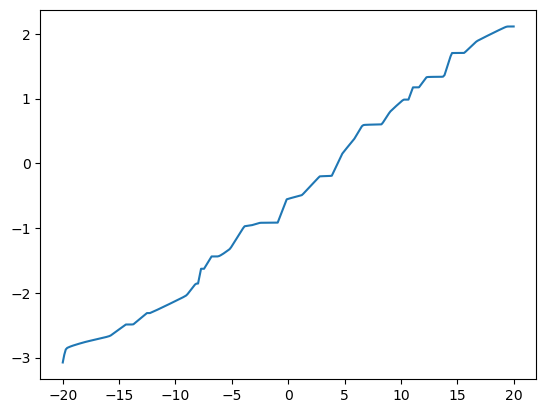

In [24]:
plt.plot(x2pos2[0], y2pos2)

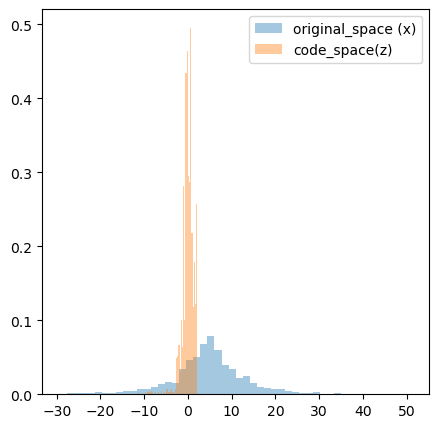

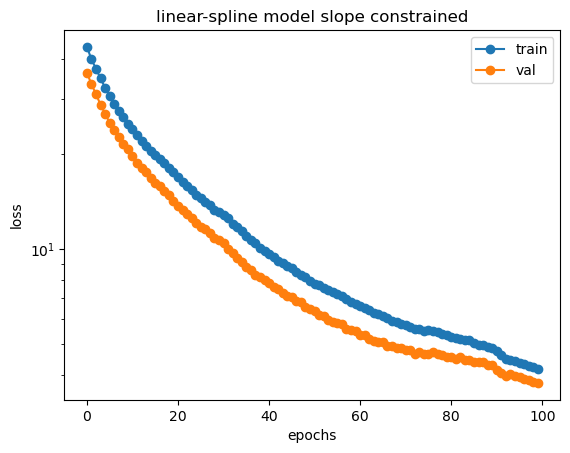

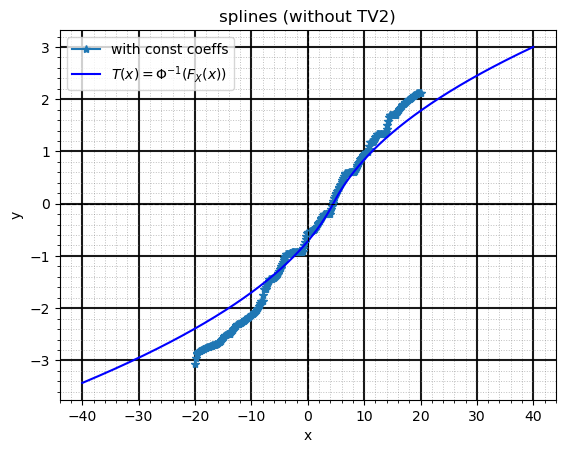

slopes: constrained coeffs: tensor([[0.8917, 0.8917, 0.6148, 0.1858, 0.0811, 0.0685, 0.0652, 0.0590, 0.0562,
         0.0537, 0.0525, 0.0523, 0.0514, 0.0486, 0.0487, 0.0467, 0.0454, 0.0422,
         0.0400, 0.0400, 0.0395, 0.0397, 0.0395, 0.0397, 0.0396, 0.0399, 0.0416,
         0.0425, 0.0425, 0.0457, 0.0492, 0.0533, 0.0822, 0.1243, 0.1264, 0.1270,
         0.1269, 0.1276, 0.1274, 0.1276, 0.1267, 0.1243, 0.1200, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0234, 0.1443, 0.1443, 0.1453, 0.1452, 0.1447, 0.1442,
         0.1436, 0.1441, 0.1405, 0.0010, 0.0010, 0.0753, 0.0766, 0.0772, 0.0799,
         0.0809, 0.0816, 0.0828, 0.0831, 0.0831, 0.0837, 0.0837, 0.0838, 0.0842,
         0.0843, 0.0842, 0.0842, 0.0845, 0.0854, 0.0855, 0.0856, 0.0883, 0.0896,
         0.0930, 0.1020, 0.1668, 0.2223, 0.2233, 0.2235, 0.2234, 0.2236, 0.1097,
         0.0010, 0.8564, 0.8564, 0.0010, 0.0010, 0.2850, 0.2850, 0.2848, 0.2848,
         0.2845, 0.0010, 0.0010, 0.0010, 0.0010, 0.0437, 0.0845, 0.1022, 0.1127,


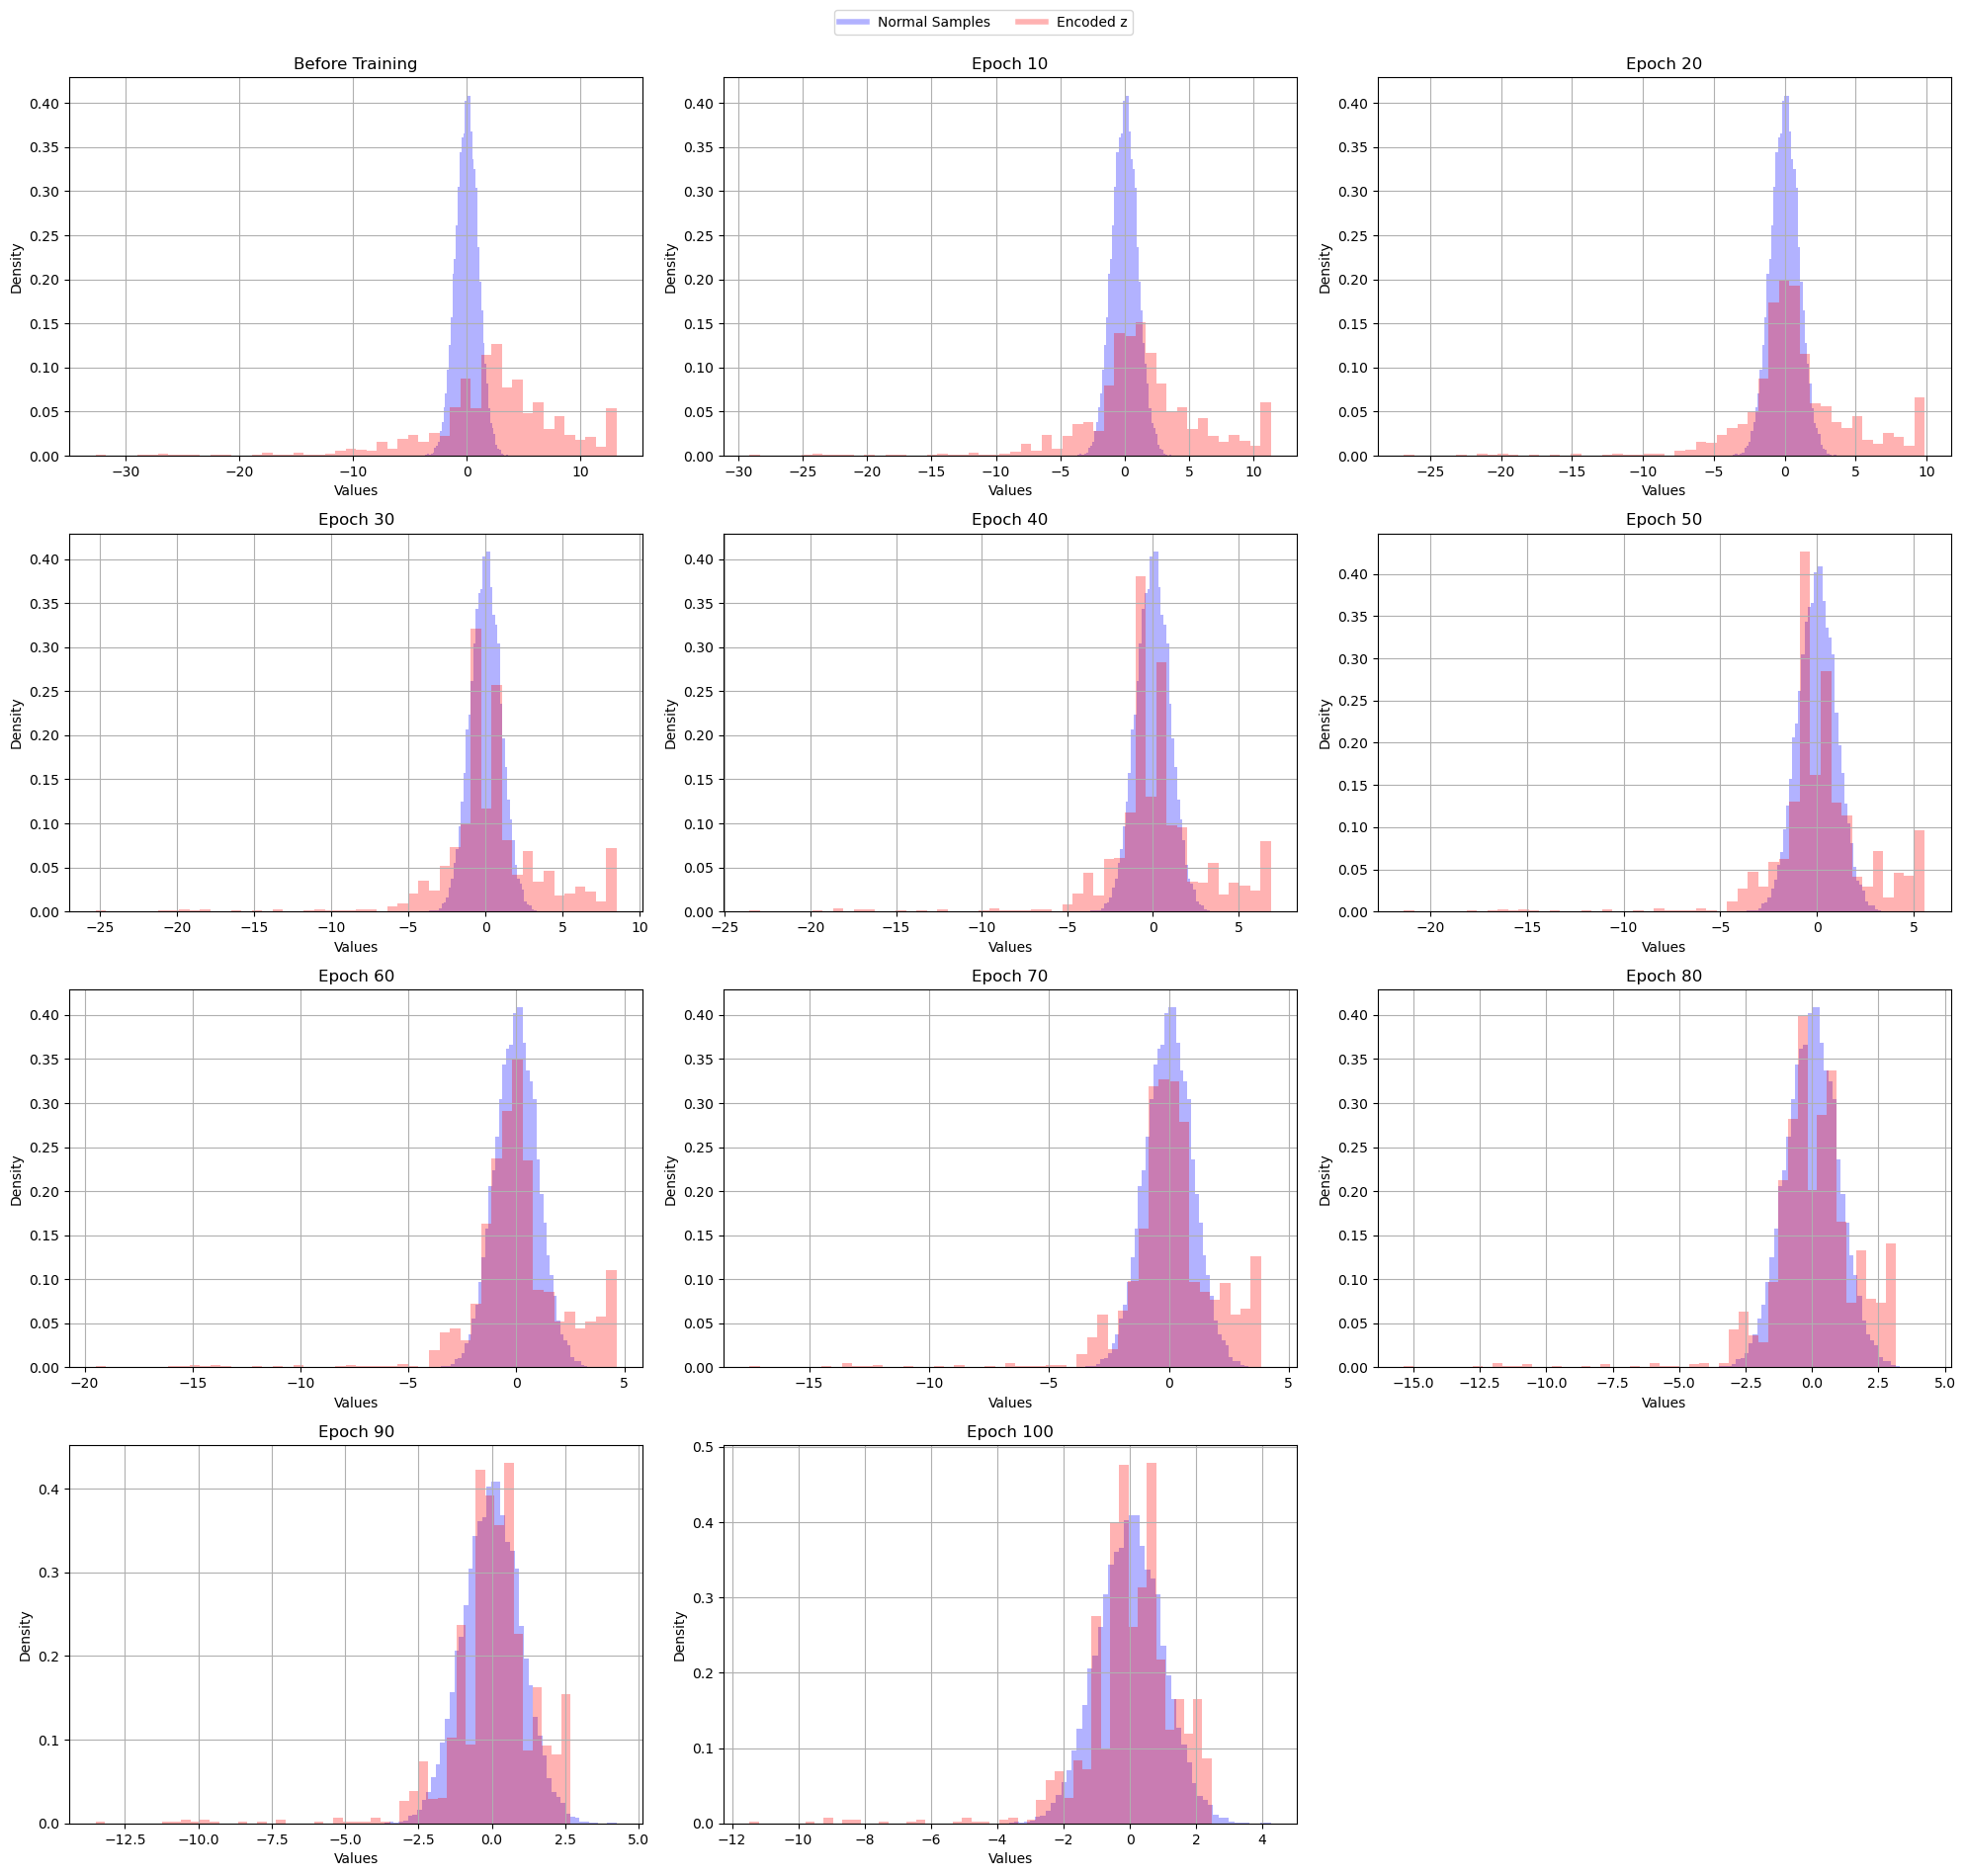

In [26]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=test_data, figsize=(20,20),
                model_params_list=epoch_wise_param_list,
                num_coeffs=10,print_model_params=0, plot_freq=10) # 40 more (30 below+40 x3 below + 40  more= 70+40+40 + 40=110+40 +40=150+40=190)

In [27]:
from scipy.interpolate import CubicSpline

In [29]:
def create_spline_interpolator(x, y, kind='cubic'):
    """
    Creates an interpolation function based on given x and y values.
    
    Parameters:
    - x: array-like, input x values.
    - y: array-like, corresponding y values.
    - kind: str, type of interpolation ('linear', 'quadratic', 'cubic').
    
    Returns:
    - interp_function: function that takes new x values and returns interpolated y values.
    """
    if kind == 'cubic':
        interp_function = CubicSpline(x, y)
    else:
        from scipy.interpolate import interp1d
        interp_function = interp1d(x, y, kind=kind, fill_value="extrapolate")
    
    return interp_function  # This function can now be used for new x values

In [30]:
xdata, ydata = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()

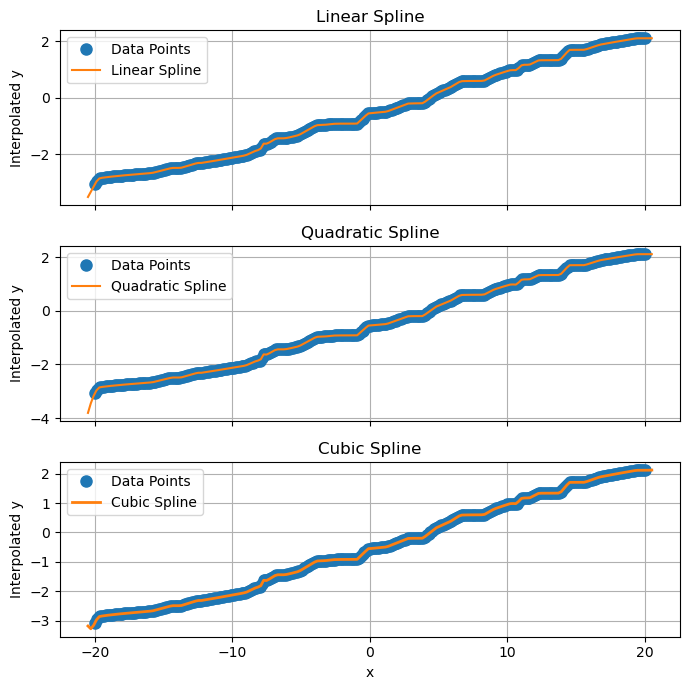

In [31]:
from scipy.interpolate import interp1d, CubicSpline

def create_spline_interpolators(x, y):
    """
    Creates linear, quadratic, and cubic spline interpolators.

    Parameters:
    - x: array-like, input x values.
    - y: array-like, corresponding y values.

    Returns:
    - Dictionary containing interpolation functions for each kind.
    """
    inter_fns = {
        'linear': interp1d(x, y, kind='linear', fill_value="extrapolate"),
        'quadratic': interp1d(x, y, kind='quadratic', fill_value="extrapolate"),
        'cubic': CubicSpline(x, y)  # Equivalent to interp1d with kind='cubic'
    }
    return inter_fns

# Get interpolators
interpolators = create_spline_interpolators(xdata[0], ydata)

# Generate dense x values for smooth plotting
x_dense = np.linspace(xdata.min() - 0.5, xdata.max() + 0.5, 200)

# Compute interpolated values for each method
y_linear = interpolators['linear'](x_dense)
y_quadratic = interpolators['quadratic'](x_dense)
y_cubic = interpolators['cubic'](x_dense)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)

# Linear Spline
axes[0].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
axes[0].plot(x_dense, y_linear, '-', label='Linear Spline', linewidth=1.5)
axes[0].set_ylabel("Interpolated y")
axes[0].set_title("Linear Spline")
axes[0].legend()
axes[0].grid(True)

# Quadratic Spline
axes[1].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
axes[1].plot(x_dense, y_quadratic, '-', label='Quadratic Spline', linewidth=1.5)
axes[1].set_ylabel("Interpolated y")
axes[1].set_title("Quadratic Spline")
axes[1].legend()
axes[1].grid(True)

# Cubic Spline
axes[2].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
axes[2].plot(x_dense, y_cubic, '-', label='Cubic Spline', linewidth=2)
axes[2].set_xlabel("x")
axes[2].set_ylabel("Interpolated y")
axes[2].set_title("Cubic Spline")
axes[2].legend()
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [32]:
interpolators

{'linear': <scipy.interpolate._interpolate.interp1d at 0x78a384262db0>,
 'quadratic': <scipy.interpolate._interpolate.interp1d at 0x78a384268c20>,
 'cubic': <scipy.interpolate._cubic.CubicSpline at 0x78a3840ac540>}

In [33]:
y_lin, y_quad, y_cubic = interpolators['linear'](test_data), interpolators['quadratic'](test_data), interpolators['cubic'](test_data)
with torch.no_grad():
    model_op = model2(torch.tensor(test_data, dtype=torch.float))

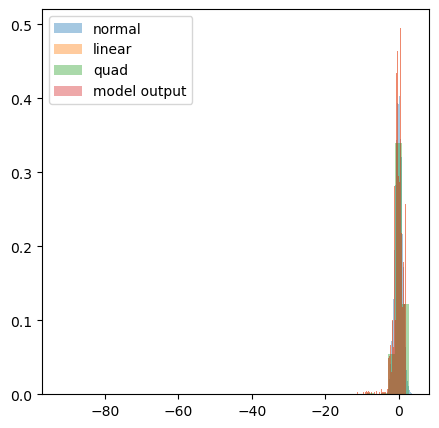

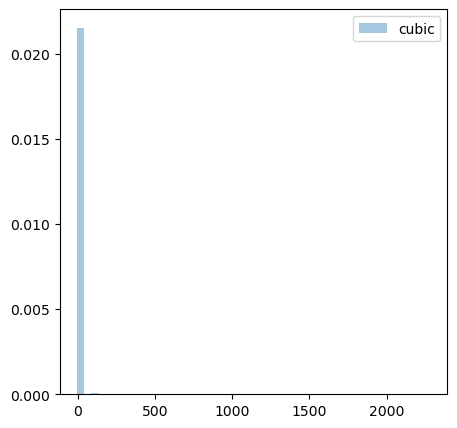

In [34]:
plot_multiple_histogram([np.random.normal(0, 1, num_samples), 
                        y_lin,
                        y_quad, 
                        #y_cubic,
                        model_op.squeeze().numpy()
                        ],
                        labels_list=["normal", 
                                     "linear",
                                     "quad", 
                                     #"cubic",
                                     "model output"
                                     ])

plot_multiple_histogram([ 
                        y_cubic
             
                        ],
                        labels_list=[
                                     "cubic"
               
                                     ])

In [35]:
# 2ND TIME training 100 more rounds
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=100, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.000095,#0.004
    print_after=1,   
    track_coefficients=1, #
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.001,#0.095, 
    gamma = 0.5, # schedular, learning rate decay factor
    alpha_nll=1
) 

Training Progress:   1%|          | 1/100 [00:09<15:53,  9.63s/it]

Epoch 1/100,  train NLL+0.001XTV2: 4.084607860801531, data avg loss-1: 1.0765805848554029 ,data avg loss-2: -2.998161010366071 ,Training NLL Loss: 4.0747415952214725, Validation NLL Loss: 3.6232652242187418, LR: 9.5e-05


Training Progress:   2%|▏         | 2/100 [00:18<15:20,  9.40s/it]

Epoch 2/100,  train NLL+0.001XTV2: 3.9621757864220797, data avg loss-1: 1.035366226666569 ,data avg loss-2: -2.917292847437466 ,Training NLL Loss: 3.952659074104038, Validation NLL Loss: 3.587801553456365, LR: 9.5e-05


Training Progress:   3%|▎         | 3/100 [00:28<15:10,  9.38s/it]

Epoch 3/100,  train NLL+0.001XTV2: 3.8926527880186366, data avg loss-1: 1.007570677514711 ,data avg loss-2: -2.875872366757765 ,Training NLL Loss: 3.883443044272479, Validation NLL Loss: 3.546649634789431, LR: 9.5e-05


Training Progress:   4%|▍         | 4/100 [00:37<14:54,  9.32s/it]

Epoch 4/100,  train NLL+0.001XTV2: 3.869148205454906, data avg loss-1: 0.9931131333741993 ,data avg loss-2: -2.8670846224319932 ,Training NLL Loss: 3.8601977558061935, Validation NLL Loss: 3.4706156616298958, LR: 9.5e-05


Training Progress:   5%|▌         | 5/100 [00:46<14:41,  9.28s/it]

Epoch 5/100,  train NLL+0.001XTV2: 3.8200725917340494, data avg loss-1: 0.9813584949681314 ,data avg loss-2: -2.830038976984846 ,Training NLL Loss: 3.811397471952981, Validation NLL Loss: 3.476220627477031, LR: 9.5e-05


Training Progress:   6%|▌         | 6/100 [00:56<14:39,  9.36s/it]

Epoch 6/100,  train NLL+0.001XTV2: 3.723961531480094, data avg loss-1: 0.9524694910173568 ,data avg loss-2: -2.7630814772758576 ,Training NLL Loss: 3.715550968293218, Validation NLL Loss: 3.417872115058521, LR: 9.5e-05


Training Progress:   7%|▋         | 7/100 [01:06<14:48,  9.55s/it]

Epoch 7/100,  train NLL+0.001XTV2: 3.694697597993078, data avg loss-1: 0.9254068131019852 ,data avg loss-2: -2.761190534926879 ,Training NLL Loss: 3.6865973480288656, Validation NLL Loss: 3.366884477767518, LR: 9.5e-05


Training Progress:   8%|▊         | 8/100 [01:15<14:40,  9.57s/it]

Epoch 8/100,  train NLL+0.001XTV2: 3.6177427591356506, data avg loss-1: 0.8929554068291276 ,data avg loss-2: -2.7170358754859674 ,Training NLL Loss: 3.6099912823150926, Validation NLL Loss: 3.326931523286847, LR: 9.5e-05


Training Progress:   9%|▉         | 9/100 [01:25<14:28,  9.54s/it]

Epoch 9/100,  train NLL+0.001XTV2: 3.571444855248707, data avg loss-1: 0.8787368621560707 ,data avg loss-2: -2.6852012467928064 ,Training NLL Loss: 3.5639381089488755, Validation NLL Loss: 3.2945878560906983, LR: 9.5e-05


Training Progress:  10%|█         | 10/100 [01:34<14:24,  9.60s/it]

Epoch 10/100,  train NLL+0.001XTV2: 3.541287501242014, data avg loss-1: 0.8683508354712066 ,data avg loss-2: -2.665657071441756 ,Training NLL Loss: 3.5340079069129615, Validation NLL Loss: 3.263692111722306, LR: 9.5e-05


Training Progress:  11%|█         | 11/100 [01:44<14:22,  9.69s/it]

Epoch 11/100,  train NLL+0.001XTV2: 3.507928610716685, data avg loss-1: 0.8469771469438622 ,data avg loss-2: -2.653887544844872 ,Training NLL Loss: 3.5008646917887343, Validation NLL Loss: 3.2229788542053743, LR: 9.5e-05


Training Progress:  12%|█▏        | 12/100 [01:54<14:13,  9.70s/it]

Epoch 12/100,  train NLL+0.001XTV2: 3.468506618778243, data avg loss-1: 0.8344213751761723 ,data avg loss-2: -2.6272455797966283 ,Training NLL Loss: 3.4616669549728027, Validation NLL Loss: 3.218898524738063, LR: 9.5e-05


Training Progress:  13%|█▎        | 13/100 [02:04<14:00,  9.66s/it]

Epoch 13/100,  train NLL+0.001XTV2: 3.440629529933287, data avg loss-1: 0.8230174557708048 ,data avg loss-2: -2.6110264122299203 ,Training NLL Loss: 3.4340438680007273, Validation NLL Loss: 3.1933579927758533, LR: 9.5e-05


Training Progress:  14%|█▍        | 14/100 [02:13<13:45,  9.60s/it]

Epoch 14/100,  train NLL+0.001XTV2: 3.4186929547997016, data avg loss-1: 0.7974675678317457 ,data avg loss-2: -2.6148663060029897 ,Training NLL Loss: 3.412333873834736, Validation NLL Loss: 3.1845522827234194, LR: 9.5e-05


Training Progress:  15%|█▌        | 15/100 [02:22<13:27,  9.50s/it]

Epoch 15/100,  train NLL+0.001XTV2: 3.41366223936377, data avg loss-1: 0.786707542609431 ,data avg loss-2: -2.620762184771655 ,Training NLL Loss: 3.4074697273810863, Validation NLL Loss: 3.179578765649418, LR: 9.5e-05


Training Progress:  16%|█▌        | 16/100 [02:32<13:10,  9.41s/it]

Epoch 16/100,  train NLL+0.001XTV2: 3.3776672469862006, data avg loss-1: 0.7736985878497378 ,data avg loss-2: -2.5979304338925315 ,Training NLL Loss: 3.371629021742268, Validation NLL Loss: 3.158001695147058, LR: 9.5e-05


Training Progress:  17%|█▋        | 17/100 [02:41<13:12,  9.54s/it]

Epoch 17/100,  train NLL+0.001XTV2: 3.3559035707546427, data avg loss-1: 0.7594598207072061 ,data avg loss-2: -2.59054726349128 ,Training NLL Loss: 3.3500070841984853, Validation NLL Loss: 3.1479042572209046, LR: 9.5e-05


Training Progress:  18%|█▊        | 18/100 [02:51<12:58,  9.49s/it]

Epoch 18/100,  train NLL+0.001XTV2: 3.331326138088012, data avg loss-1: 0.73587449059174 ,data avg loss-2: -2.5896664081667105 ,Training NLL Loss: 3.3255408987584505, Validation NLL Loss: 3.1375639180728996, LR: 9.5e-05


Training Progress:  19%|█▉        | 19/100 [03:00<12:49,  9.50s/it]

Epoch 19/100,  train NLL+0.001XTV2: 3.2748339545539373, data avg loss-1: 0.7068696527169751 ,data avg loss-2: -2.5623521557795095 ,Training NLL Loss: 3.269221808496483, Validation NLL Loss: 3.090491672973573, LR: 9.5e-05


Training Progress:  20%|██        | 20/100 [03:10<12:38,  9.48s/it]

Epoch 20/100,  train NLL+0.001XTV2: 3.246843834224221, data avg loss-1: 0.7018446464763349 ,data avg loss-2: -2.539555462244437 ,Training NLL Loss: 3.241400108720772, Validation NLL Loss: 3.0626930560898504, LR: 9.5e-05


Training Progress:  21%|██        | 21/100 [03:19<12:19,  9.36s/it]

Epoch 21/100,  train NLL+0.001XTV2: 3.2066534509104745, data avg loss-1: 0.681581086638698 ,data avg loss-2: -2.5197249402686164 ,Training NLL Loss: 3.201306026907312, Validation NLL Loss: 3.0430614715614155, LR: 9.5e-05


Training Progress:  22%|██▏       | 22/100 [03:28<12:11,  9.38s/it]

Epoch 22/100,  train NLL+0.001XTV2: 3.1925381455566595, data avg loss-1: 0.675960642964976 ,data avg loss-2: -2.511437686680565 ,Training NLL Loss: 3.187398329645541, Validation NLL Loss: 3.035867649695377, LR: 9.5e-05


Training Progress:  23%|██▎       | 23/100 [03:38<12:01,  9.37s/it]

Epoch 23/100,  train NLL+0.001XTV2: 3.177701241311414, data avg loss-1: 0.6707165432465199 ,data avg loss-2: -2.501960942521962 ,Training NLL Loss: 3.17267748576848, Validation NLL Loss: 3.0268243910429606, LR: 9.5e-05


Training Progress:  24%|██▍       | 24/100 [03:47<11:50,  9.35s/it]

Epoch 24/100,  train NLL+0.001XTV2: 3.1610861632258516, data avg loss-1: 0.6610621405342072 ,data avg loss-2: -2.4951647672351434 ,Training NLL Loss: 3.1562269077693528, Validation NLL Loss: 2.993016254358675, LR: 9.5e-05


Training Progress:  25%|██▌       | 25/100 [03:56<11:43,  9.38s/it]

Epoch 25/100,  train NLL+0.001XTV2: 3.139378565407608, data avg loss-1: 0.6552042819463787 ,data avg loss-2: -2.4794732341426937 ,Training NLL Loss: 3.134677516089071, Validation NLL Loss: 2.9715655038081423, LR: 9.5e-05


Training Progress:  26%|██▌       | 26/100 [04:06<11:29,  9.32s/it]

Epoch 26/100,  train NLL+0.001XTV2: 3.1163319458254968, data avg loss-1: 0.6439936817495845 ,data avg loss-2: -2.46777919867569 ,Training NLL Loss: 3.1117728804252733, Validation NLL Loss: 2.971301545574076, LR: 9.5e-05


Training Progress:  27%|██▋       | 27/100 [04:15<11:15,  9.26s/it]

Epoch 27/100,  train NLL+0.001XTV2: 3.107365541155778, data avg loss-1: 0.6420888620589152 ,data avg loss-2: -2.4607974324464386 ,Training NLL Loss: 3.1028862945053546, Validation NLL Loss: 2.964195526191229, LR: 9.5e-05


Training Progress:  28%|██▊       | 28/100 [04:24<11:10,  9.31s/it]

Epoch 28/100,  train NLL+0.001XTV2: 3.0987981099737576, data avg loss-1: 0.6401660330923273 ,data avg loss-2: -2.4542291737772284 ,Training NLL Loss: 3.0943952068695566, Validation NLL Loss: 2.9511316158615077, LR: 9.5e-05


Training Progress:  29%|██▉       | 29/100 [04:34<11:08,  9.41s/it]

Epoch 29/100,  train NLL+0.001XTV2: 3.0774042403464255, data avg loss-1: 0.6215285899367862 ,data avg loss-2: -2.451673518126063 ,Training NLL Loss: 3.0732021080628487, Validation NLL Loss: 2.9476435565857093, LR: 9.5e-05


Training Progress:  30%|███       | 30/100 [04:43<10:59,  9.43s/it]

Epoch 30/100,  train NLL+0.001XTV2: 3.0588667510764007, data avg loss-1: 0.6045602372336351 ,data avg loss-2: -2.4502552031952165 ,Training NLL Loss: 3.0548154404288557, Validation NLL Loss: 2.94271044264723, LR: 9.5e-05


Training Progress:  31%|███       | 31/100 [04:53<10:56,  9.51s/it]

Epoch 31/100,  train NLL+0.001XTV2: 3.040243167133709, data avg loss-1: 0.5809538140100595 ,data avg loss-2: -2.455379881332276 ,Training NLL Loss: 3.036333695342338, Validation NLL Loss: 2.9302343884636457, LR: 9.5e-05


Training Progress:  32%|███▏      | 32/100 [05:02<10:41,  9.43s/it]

Epoch 32/100,  train NLL+0.001XTV2: 3.015245298579173, data avg loss-1: 0.570026227975096 ,data avg loss-2: -2.4414243701732388 ,Training NLL Loss: 3.011450598148334, Validation NLL Loss: 2.929058600606915, LR: 9.5e-05


Training Progress:  33%|███▎      | 33/100 [05:11<10:27,  9.37s/it]

Epoch 33/100,  train NLL+0.001XTV2: 3.0087461312315833, data avg loss-1: 0.5634578942482525 ,data avg loss-2: -2.4415599026177865 ,Training NLL Loss: 3.0050177968660376, Validation NLL Loss: 2.9168049004948564, LR: 9.5e-05


Training Progress:  34%|███▍      | 34/100 [05:20<10:13,  9.29s/it]

Epoch 34/100,  train NLL+0.001XTV2: 2.987346015905015, data avg loss-1: 0.5565913199446691 ,data avg loss-2: -2.4270987572885776 ,Training NLL Loss: 2.983690077233246, Validation NLL Loss: 2.899321548705142, LR: 9.5e-05


Training Progress:  35%|███▌      | 35/100 [05:30<10:06,  9.33s/it]

Epoch 35/100,  train NLL+0.001XTV2: 2.9798591555420613, data avg loss-1: 0.5588151696845783 ,data avg loss-2: -2.4175227264071304 ,Training NLL Loss: 2.9763378960917075, Validation NLL Loss: 2.9017526299105914, LR: 9.5e-05


Training Progress:  36%|███▌      | 36/100 [05:39<09:58,  9.36s/it]

Epoch 36/100,  train NLL+0.001XTV2: 2.967409492621765, data avg loss-1: 0.5530053880509271 ,data avg loss-2: -2.410929928687381 ,Training NLL Loss: 2.9639353167383082, Validation NLL Loss: 2.881756327599828, LR: 9.5e-05


Training Progress:  37%|███▋      | 37/100 [05:49<09:50,  9.37s/it]

Epoch 37/100,  train NLL+0.001XTV2: 2.952736188756568, data avg loss-1: 0.5472037078385908 ,data avg loss-2: -2.402100280034994 ,Training NLL Loss: 2.949303987873585, Validation NLL Loss: 2.8676207501521573, LR: 9.5e-05


Training Progress:  38%|███▊      | 38/100 [05:58<09:44,  9.43s/it]

Epoch 38/100,  train NLL+0.001XTV2: 2.9280172249079435, data avg loss-1: 0.5334811127315924 ,data avg loss-2: -2.3911045584694253 ,Training NLL Loss: 2.924585671201018, Validation NLL Loss: 2.8546088848085516, LR: 9.5e-05


Training Progress:  39%|███▉      | 39/100 [06:08<09:37,  9.47s/it]

Epoch 39/100,  train NLL+0.001XTV2: 2.9155018811253846, data avg loss-1: 0.530418337023987 ,data avg loss-2: -2.3817198200105705 ,Training NLL Loss: 2.9121381570345597, Validation NLL Loss: 2.8456884055670213, LR: 9.5e-05


Training Progress:  40%|████      | 40/100 [06:17<09:25,  9.43s/it]

Epoch 40/100,  train NLL+0.001XTV2: 2.904991867473932, data avg loss-1: 0.5257911053762493 ,data avg loss-2: -2.3758819815222023 ,Training NLL Loss: 2.901673086898452, Validation NLL Loss: 2.8386027087540504, LR: 9.5e-05


Training Progress:  41%|████      | 41/100 [06:27<09:15,  9.42s/it]

Epoch 41/100,  train NLL+0.001XTV2: 2.903409133217558, data avg loss-1: 0.5279257767340996 ,data avg loss-2: -2.37227928311036 ,Training NLL Loss: 2.9002050598444624, Validation NLL Loss: 2.8353269450092577, LR: 9.5e-05


Training Progress:  42%|████▏     | 42/100 [06:36<09:00,  9.32s/it]

Epoch 42/100,  train NLL+0.001XTV2: 2.8975952886847582, data avg loss-1: 0.5283707504264308 ,data avg loss-2: -2.366055074357477 ,Training NLL Loss: 2.894425824783909, Validation NLL Loss: 2.8236894868708307, LR: 9.5e-05


Training Progress:  43%|████▎     | 43/100 [06:45<08:51,  9.32s/it]

Epoch 43/100,  train NLL+0.001XTV2: 2.8803840721118226, data avg loss-1: 0.5169185815198745 ,data avg loss-2: -2.360279214370837 ,Training NLL Loss: 2.877197795890707, Validation NLL Loss: 2.8195799186234325, LR: 9.5e-05


Training Progress:  44%|████▍     | 44/100 [06:54<08:41,  9.31s/it]

Epoch 44/100,  train NLL+0.001XTV2: 2.875272627841926, data avg loss-1: 0.5120435737485054 ,data avg loss-2: -2.360096973895819 ,Training NLL Loss: 2.8721405476443254, Validation NLL Loss: 2.809655096801994, LR: 9.5e-05


Training Progress:  45%|████▌     | 45/100 [07:04<08:34,  9.35s/it]

Epoch 45/100,  train NLL+0.001XTV2: 2.8688449099088236, data avg loss-1: 0.5028387069249116 ,data avg loss-2: -2.3629058850704068 ,Training NLL Loss: 2.865744591995317, Validation NLL Loss: 2.8087560546030717, LR: 9.5e-05


Training Progress:  46%|████▌     | 46/100 [07:13<08:25,  9.36s/it]

Epoch 46/100,  train NLL+0.001XTV2: 2.86474380571302, data avg loss-1: 0.5018419225489567 ,data avg loss-2: -2.359893648107709 ,Training NLL Loss: 2.861735570656668, Validation NLL Loss: 2.800790769421928, LR: 9.5e-05


Training Progress:  47%|████▋     | 47/100 [07:22<08:14,  9.33s/it]

Epoch 47/100,  train NLL+0.001XTV2: 2.8597719253601936, data avg loss-1: 0.5072676107716463 ,data avg loss-2: -2.3496174336456632 ,Training NLL Loss: 2.8568850444173073, Validation NLL Loss: 2.7883806150483315, LR: 9.5e-05


Training Progress:  48%|████▊     | 48/100 [07:32<08:04,  9.32s/it]

Epoch 48/100,  train NLL+0.001XTV2: 2.8590645295247663, data avg loss-1: 0.5059632070569573 ,data avg loss-2: -2.350244466086159 ,Training NLL Loss: 2.8562076731431127, Validation NLL Loss: 2.7832722407617934, LR: 9.5e-05


Training Progress:  49%|████▉     | 49/100 [07:41<07:57,  9.37s/it]

Epoch 49/100,  train NLL+0.001XTV2: 2.859595548928464, data avg loss-1: 0.5068502499249126 ,data avg loss-2: -2.349932603650658 ,Training NLL Loss: 2.856782853575571, Validation NLL Loss: 2.778777955121883, LR: 9.5e-05


Training Progress:  50%|█████     | 50/100 [07:51<07:49,  9.39s/it]

Epoch 50/100,  train NLL+0.001XTV2: 2.8578061205255643, data avg loss-1: 0.5092009912117871 ,data avg loss-2: -2.3458643830216226 ,Training NLL Loss: 2.855065374233412, Validation NLL Loss: 2.7803787704623697, LR: 9.5e-05


Training Progress:  51%|█████     | 51/100 [08:00<07:42,  9.44s/it]

Epoch 51/100,  train NLL+0.001XTV2: 2.852409475365291, data avg loss-1: 0.5041567190472573 ,data avg loss-2: -2.3455292958591483 ,Training NLL Loss: 2.849686014906407, Validation NLL Loss: 2.776279777319267, LR: 9.5e-05


Training Progress:  52%|█████▏    | 52/100 [08:09<07:30,  9.39s/it]

Epoch 52/100,  train NLL+0.001XTV2: 2.8493264654736477, data avg loss-1: 0.502572054603662 ,data avg loss-2: -2.344101972052173 ,Training NLL Loss: 2.846674026655836, Validation NLL Loss: 2.773373595388585, LR: 9.5e-05


Training Progress:  53%|█████▎    | 53/100 [08:19<07:20,  9.38s/it]

Epoch 53/100,  train NLL+0.001XTV2: 2.845196049189636, data avg loss-1: 0.4998834240136945 ,data avg loss-2: -2.3427245534399677 ,Training NLL Loss: 2.842607977453661, Validation NLL Loss: 2.7671292762824953, LR: 9.5e-05


Training Progress:  54%|█████▍    | 54/100 [08:28<07:12,  9.41s/it]

Epoch 54/100,  train NLL+0.001XTV2: 2.839149150889384, data avg loss-1: 0.4981872006743773 ,data avg loss-2: -2.338388269932037 ,Training NLL Loss: 2.836575470606414, Validation NLL Loss: 2.7617513163497285, LR: 9.5e-05


Training Progress:  55%|█████▌    | 55/100 [08:38<07:02,  9.39s/it]

Epoch 55/100,  train NLL+0.001XTV2: 2.836644184498287, data avg loss-1: 0.494617591207012 ,data avg loss-2: -2.3394523407904138 ,Training NLL Loss: 2.834069931997423, Validation NLL Loss: 2.7607790087716295, LR: 9.5e-05


Training Progress:  56%|█████▌    | 56/100 [08:47<06:54,  9.42s/it]

Epoch 56/100,  train NLL+0.001XTV2: 2.835006138346771, data avg loss-1: 0.4965569740854527 ,data avg loss-2: -2.3359277645660255 ,Training NLL Loss: 2.8324847386514773, Validation NLL Loss: 2.759396921211821, LR: 9.5e-05


Training Progress:  57%|█████▋    | 57/100 [08:56<06:43,  9.39s/it]

Epoch 57/100,  train NLL+0.001XTV2: 2.8356497772304725, data avg loss-1: 0.48955224905751876 ,data avg loss-2: -2.343615923826082 ,Training NLL Loss: 2.8331681728836, Validation NLL Loss: 2.770269619443483, LR: 9.5e-05


Training Progress:  58%|█████▊    | 58/100 [09:06<06:33,  9.37s/it]

Epoch 58/100,  train NLL+0.001XTV2: 2.8577266247616566, data avg loss-1: 0.48522704883652523 ,data avg loss-2: -2.3700128491324692 ,Training NLL Loss: 2.8552398979689944, Validation NLL Loss: 2.771654660638424, LR: 9.5e-05


Training Progress:  59%|█████▉    | 59/100 [09:15<06:24,  9.37s/it]

Epoch 59/100,  train NLL+0.001XTV2: 2.8530917103238966, data avg loss-1: 0.48478547939169137 ,data avg loss-2: -2.365861070336636 ,Training NLL Loss: 2.8506465497283298, Validation NLL Loss: 2.7665118933046644, LR: 4.75e-05


Training Progress:  60%|██████    | 60/100 [09:25<06:15,  9.39s/it]

Epoch 60/100,  train NLL+0.001XTV2: 2.852536036148836, data avg loss-1: 0.48494893039051507 ,data avg loss-2: -2.365183354251055 ,Training NLL Loss: 2.850132284641568, Validation NLL Loss: 2.7666882120312613, LR: 4.75e-05


Training Progress:  61%|██████    | 61/100 [09:34<06:09,  9.47s/it]

Epoch 61/100,  train NLL+0.001XTV2: 2.8507548239595657, data avg loss-1: 0.4844029516401444 ,data avg loss-2: -2.363978189627173 ,Training NLL Loss: 2.8483811412673177, Validation NLL Loss: 2.766239471166991, LR: 4.75e-05


Training Progress:  62%|██████▏   | 62/100 [09:44<05:58,  9.44s/it]

Epoch 62/100,  train NLL+0.001XTV2: 2.8501274147838696, data avg loss-1: 0.48519838299112594 ,data avg loss-2: -2.3625541201538334 ,Training NLL Loss: 2.8477525031449615, Validation NLL Loss: 2.759515097090682, LR: 2.375e-05


Training Progress:  63%|██████▎   | 63/100 [09:53<05:49,  9.45s/it]

Epoch 63/100,  train NLL+0.001XTV2: 2.8477845244676723, data avg loss-1: 0.48579914550396863 ,data avg loss-2: -2.359625366325321 ,Training NLL Loss: 2.8454245118292896, Validation NLL Loss: 2.7611123711828522, LR: 2.375e-05


Training Progress:  64%|██████▍   | 64/100 [10:03<05:41,  9.47s/it]

Epoch 64/100,  train NLL+0.001XTV2: 2.8477821047415377, data avg loss-1: 0.4855100317201833 ,data avg loss-2: -2.3599279938952837 ,Training NLL Loss: 2.845438025615466, Validation NLL Loss: 2.762716752921043, LR: 2.375e-05


Training Progress:  65%|██████▌   | 65/100 [10:12<05:29,  9.41s/it]

Epoch 65/100,  train NLL+0.001XTV2: 2.8474878078431556, data avg loss-1: 0.48546678821681616 ,data avg loss-2: -2.359686771099652 ,Training NLL Loss: 2.8451535593164685, Validation NLL Loss: 2.7625730832126583, LR: 1.1875e-05


Training Progress:  66%|██████▌   | 66/100 [10:21<05:17,  9.35s/it]

Epoch 66/100,  train NLL+0.001XTV2: 2.8479319981332276, data avg loss-1: 0.4855136380535494 ,data avg loss-2: -2.3600979198630228 ,Training NLL Loss: 2.8456115579165724, Validation NLL Loss: 2.7605394670440777, LR: 1.1875e-05


Training Progress:  67%|██████▋   | 67/100 [10:31<05:11,  9.44s/it]

Epoch 67/100,  train NLL+0.001XTV2: 2.847617235595611, data avg loss-1: 0.48553391881038893 ,data avg loss-2: -2.359767050471629 ,Training NLL Loss: 2.845300969282017, Validation NLL Loss: 2.7616987442879593, LR: 1.1875e-05


Training Progress:  68%|██████▊   | 68/100 [10:40<05:01,  9.43s/it]

Epoch 68/100,  train NLL+0.001XTV2: 2.847520599248189, data avg loss-1: 0.48547677629863245 ,data avg loss-2: -2.3597325724406626 ,Training NLL Loss: 2.845209348739293, Validation NLL Loss: 2.7613947778046253, LR: 5.9375e-06


Training Progress:  69%|██████▉   | 69/100 [10:49<04:51,  9.41s/it]

Epoch 69/100,  train NLL+0.001XTV2: 2.8479423681991194, data avg loss-1: 0.4852957391122815 ,data avg loss-2: -2.3603458466589835 ,Training NLL Loss: 2.8456415857712622, Validation NLL Loss: 2.7627354121897025, LR: 5.9375e-06


Training Progress:  70%|███████   | 70/100 [10:59<04:44,  9.49s/it]

Epoch 70/100,  train NLL+0.001XTV2: 2.848141305123879, data avg loss-1: 0.4852485283994301 ,data avg loss-2: -2.360595242753724 ,Training NLL Loss: 2.8458437711531537, Validation NLL Loss: 2.7623620155742286, LR: 5.9375e-06


Training Progress:  71%|███████   | 71/100 [11:09<04:35,  9.49s/it]

Epoch 71/100,  train NLL+0.001XTV2: 2.8482134727091886, data avg loss-1: 0.4851425401321578 ,data avg loss-2: -2.360778212169653 ,Training NLL Loss: 2.845920752301808, Validation NLL Loss: 2.7627319047510217, LR: 2.96875e-06


Training Progress:  72%|███████▏  | 72/100 [11:18<04:24,  9.44s/it]

Epoch 72/100,  train NLL+0.001XTV2: 2.848161975157905, data avg loss-1: 0.485102448044111 ,data avg loss-2: -2.360770749329482 ,Training NLL Loss: 2.8458731973735936, Validation NLL Loss: 2.7624634368968364, LR: 2.96875e-06


Training Progress:  73%|███████▎  | 73/100 [11:27<04:15,  9.45s/it]

Epoch 73/100,  train NLL+0.001XTV2: 2.8481953341285395, data avg loss-1: 0.48509526882060616 ,data avg loss-2: -2.360812676514741 ,Training NLL Loss: 2.845907945335347, Validation NLL Loss: 2.7625672283621574, LR: 2.96875e-06


Training Progress:  74%|███████▍  | 74/100 [11:37<04:06,  9.50s/it]

Epoch 74/100,  train NLL+0.001XTV2: 2.8482925354344957, data avg loss-1: 0.4850735639166803 ,data avg loss-2: -2.3609335875986948 ,Training NLL Loss: 2.8460071515153746, Validation NLL Loss: 2.7622665268016817, LR: 1.484375e-06


Training Progress:  75%|███████▌  | 75/100 [11:47<03:58,  9.52s/it]

Epoch 75/100,  train NLL+0.001XTV2: 2.8482391788242802, data avg loss-1: 0.4851093686192738 ,data avg loss-2: -2.360845399592482 ,Training NLL Loss: 2.8459547682117554, Validation NLL Loss: 2.7627008279279233, LR: 1.484375e-06


Training Progress:  76%|███████▌  | 76/100 [11:56<03:49,  9.55s/it]

Epoch 76/100,  train NLL+0.001XTV2: 2.848310619709747, data avg loss-1: 0.4851211996730098 ,data avg loss-2: -2.3609056259464527 ,Training NLL Loss: 2.8460268256194623, Validation NLL Loss: 2.762482976262644, LR: 1.484375e-06


Training Progress:  77%|███████▋  | 77/100 [12:06<03:40,  9.60s/it]

Epoch 77/100,  train NLL+0.001XTV2: 2.8482683417024215, data avg loss-1: 0.4851195744614391 ,data avg loss-2: -2.360865810643855 ,Training NLL Loss: 2.8459853851052923, Validation NLL Loss: 2.7627463819490057, LR: 7.421875e-07


Training Progress:  78%|███████▊  | 78/100 [12:15<03:29,  9.50s/it]

Epoch 78/100,  train NLL+0.001XTV2: 2.8482871853469947, data avg loss-1: 0.4850876320187241 ,data avg loss-2: -2.3609181388563036 ,Training NLL Loss: 2.8460057708750286, Validation NLL Loss: 2.762628027346715, LR: 7.421875e-07


Training Progress:  79%|███████▉  | 79/100 [12:24<03:16,  9.36s/it]

Epoch 79/100,  train NLL+0.001XTV2: 2.8482441268495955, data avg loss-1: 0.4850813759146993 ,data avg loss-2: -2.360881900460572 ,Training NLL Loss: 2.845963276375272, Validation NLL Loss: 2.7627123268826947, LR: 7.421875e-07


Training Progress:  80%|████████  | 80/100 [12:34<03:08,  9.43s/it]

Epoch 80/100,  train NLL+0.001XTV2: 2.8482046702642667, data avg loss-1: 0.4850768622672508 ,data avg loss-2: -2.360847592192418 ,Training NLL Loss: 2.8459244544596687, Validation NLL Loss: 2.7626900520496482, LR: 3.7109375e-07


Training Progress:  81%|████████  | 81/100 [12:43<02:58,  9.42s/it]

Epoch 81/100,  train NLL+0.001XTV2: 2.8482244140916197, data avg loss-1: 0.4850659702194495 ,data avg loss-2: -2.360878885044469 ,Training NLL Loss: 2.845944855263918, Validation NLL Loss: 2.762682655900212, LR: 3.7109375e-07


Training Progress:  82%|████████▏ | 82/100 [12:53<02:49,  9.40s/it]

Epoch 82/100,  train NLL+0.001XTV2: 2.84822282297794, data avg loss-1: 0.4850580210441486 ,data avg loss-2: -2.3608856149080246 ,Training NLL Loss: 2.8459436359521715, Validation NLL Loss: 2.762487320373442, LR: 3.7109375e-07


Training Progress:  83%|████████▎ | 83/100 [13:02<02:40,  9.47s/it]

Epoch 83/100,  train NLL+0.001XTV2: 2.8481856367962637, data avg loss-1: 0.4850588298701774 ,data avg loss-2: -2.3608478197202345 ,Training NLL Loss: 2.8459066495904106, Validation NLL Loss: 2.762552039986118, LR: 1.85546875e-07


Training Progress:  84%|████████▍ | 84/100 [13:12<02:31,  9.45s/it]

Epoch 84/100,  train NLL+0.001XTV2: 2.8482007127838997, data avg loss-1: 0.48506178328182803 ,data avg loss-2: -2.3608600932050696 ,Training NLL Loss: 2.8459218764868957, Validation NLL Loss: 2.762643215272921, LR: 1.85546875e-07


Training Progress:  85%|████████▌ | 85/100 [13:21<02:21,  9.41s/it]

Epoch 85/100,  train NLL+0.001XTV2: 2.848220979028747, data avg loss-1: 0.48505699227275156 ,data avg loss-2: -2.36088533878905 ,Training NLL Loss: 2.845942331061798, Validation NLL Loss: 2.7626418785690547, LR: 1.85546875e-07


Training Progress:  86%|████████▌ | 86/100 [13:31<02:12,  9.45s/it]

Epoch 86/100,  train NLL+0.001XTV2: 2.8482212590607254, data avg loss-1: 0.48505610192245957 ,data avg loss-2: -2.360886641788993 ,Training NLL Loss: 2.84594274371145, Validation NLL Loss: 2.7625990571059487, LR: 9.27734375e-08


Training Progress:  87%|████████▋ | 87/100 [13:40<02:02,  9.41s/it]

Epoch 87/100,  train NLL+0.001XTV2: 2.8481912638285123, data avg loss-1: 0.4850588622315655 ,data avg loss-2: -2.3608539281299126 ,Training NLL Loss: 2.8459127903614787, Validation NLL Loss: 2.7625683480546974, LR: 9.27734375e-08


Training Progress:  88%|████████▊ | 88/100 [13:49<01:53,  9.42s/it]

Epoch 88/100,  train NLL+0.001XTV2: 2.8481969986778695, data avg loss-1: 0.4850595072238746 ,data avg loss-2: -2.3608590477985976 ,Training NLL Loss: 2.845918555022471, Validation NLL Loss: 2.7626127349913037, LR: 9.27734375e-08


Training Progress:  89%|████████▉ | 89/100 [13:59<01:44,  9.47s/it]

Epoch 89/100,  train NLL+0.001XTV2: 2.8481933026961093, data avg loss-1: 0.4850590516045086 ,data avg loss-2: -2.3608558723440636 ,Training NLL Loss: 2.845914923948572, Validation NLL Loss: 2.7625159387799147, LR: 4.638671875e-08


Training Progress:  90%|█████████ | 90/100 [14:09<01:35,  9.56s/it]

Epoch 90/100,  train NLL+0.001XTV2: 2.8481671441177894, data avg loss-1: 0.4850597647815838 ,data avg loss-2: -2.360829042256705 ,Training NLL Loss: 2.84588880703829, Validation NLL Loss: 2.7625056742373655, LR: 4.638671875e-08


Training Progress:  91%|█████████ | 91/100 [14:18<01:26,  9.56s/it]

Epoch 91/100,  train NLL+0.001XTV2: 2.848161879872867, data avg loss-1: 0.4850585079497281 ,data avg loss-2: -2.3608250880946677 ,Training NLL Loss: 2.845883596044397, Validation NLL Loss: 2.7625138672416414, LR: 4.638671875e-08


Training Progress:  92%|█████████▏| 92/100 [14:27<01:15,  9.48s/it]

Epoch 92/100,  train NLL+0.001XTV2: 2.8481672928744937, data avg loss-1: 0.485057941558161 ,data avg loss-2: -2.3608310994362167 ,Training NLL Loss: 2.845889040994379, Validation NLL Loss: 2.7625051079772933, LR: 2.3193359375e-08


Training Progress:  93%|█████████▎| 93/100 [14:37<01:06,  9.51s/it]

Epoch 93/100,  train NLL+0.001XTV2: 2.8481664846513124, data avg loss-1: 0.48505836646175265 ,data avg loss-2: -2.360829888310611 ,Training NLL Loss: 2.845888254772363, Validation NLL Loss: 2.7625077153535527, LR: 2.3193359375e-08


Training Progress:  94%|█████████▍| 94/100 [14:47<00:57,  9.53s/it]

Epoch 94/100,  train NLL+0.001XTV2: 2.8481648253642415, data avg loss-1: 0.48505781543810356 ,data avg loss-2: -2.3608288059273113 ,Training NLL Loss: 2.845886621365416, Validation NLL Loss: 2.762506025523055, LR: 2.3193359375e-08


Training Progress:  95%|█████████▌| 95/100 [14:56<00:48,  9.60s/it]

Epoch 95/100,  train NLL+0.001XTV2: 2.8481644547890355, data avg loss-1: 0.48505744470618545 ,data avg loss-2: -2.3608288250124865 ,Training NLL Loss: 2.845886269718676, Validation NLL Loss: 2.762508994826111, LR: 1.15966796875e-08


Training Progress:  96%|█████████▌| 96/100 [15:06<00:38,  9.57s/it]

Epoch 96/100,  train NLL+0.001XTV2: 2.8481652573994976, data avg loss-1: 0.48505741376527267 ,data avg loss-2: -2.360829672836382 ,Training NLL Loss: 2.845887086601657, Validation NLL Loss: 2.7625070386246016, LR: 1.15966796875e-08


Training Progress:  97%|█████████▋| 97/100 [15:15<00:28,  9.50s/it]

Epoch 97/100,  train NLL+0.001XTV2: 2.8481652020196058, data avg loss-1: 0.48505745081113616 ,data avg loss-2: -2.3608295859613104 ,Training NLL Loss: 2.845887036772447, Validation NLL Loss: 2.762506010903819, LR: 1.15966796875e-08


Training Progress:  98%|█████████▊| 98/100 [15:25<00:19,  9.54s/it]

Epoch 98/100,  train NLL+0.001XTV2: 2.8481649282128187, data avg loss-1: 0.4850575274922673 ,data avg loss-2: -2.3608292395060193 ,Training NLL Loss: 2.8458867669982872, Validation NLL Loss: 2.762507626449737, LR: 1.15966796875e-08


Training Progress:  99%|█████████▉| 99/100 [15:35<00:09,  9.59s/it]

Epoch 99/100,  train NLL+0.001XTV2: 2.8481664698059705, data avg loss-1: 0.4850576136234946 ,data avg loss-2: -2.3608306990338326 ,Training NLL Loss: 2.8458883126573276, Validation NLL Loss: 2.762511923065782, LR: 1.15966796875e-08


Training Progress: 100%|██████████| 100/100 [15:44<00:00,  9.45s/it]

Epoch 100/100,  train NLL+0.001XTV2: 2.848167901951904, data avg loss-1: 0.48505748419420774 ,data avg loss-2: -2.3608322699342525 ,Training NLL Loss: 2.8458897541284607, Validation NLL Loss: 2.762512850223295, LR: 1.15966796875e-08
Training complete


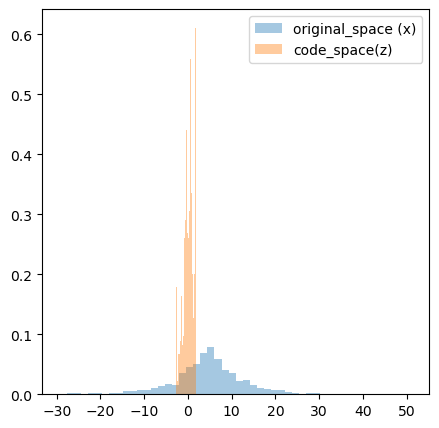

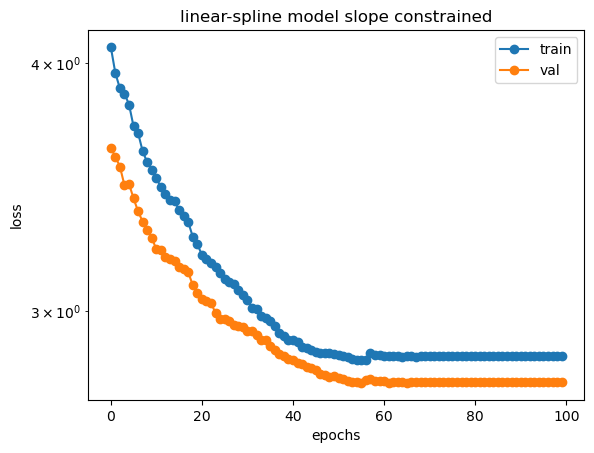

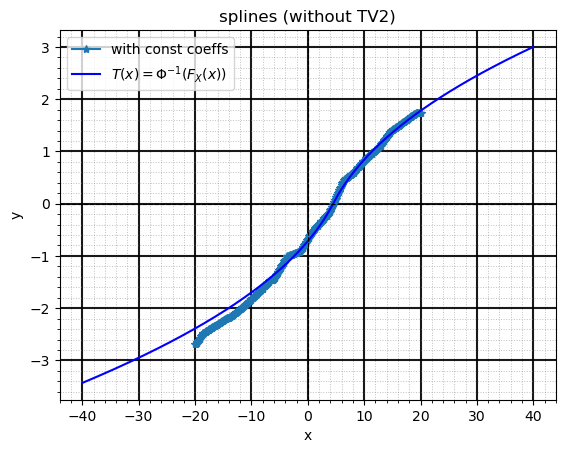

slopes: constrained coeffs: tensor([[0.0010, 0.0010, 0.1640, 0.1640, 0.1640, 0.1640, 0.1640, 0.1640, 0.1640,
         0.1640, 0.1640, 0.0975, 0.0811, 0.0779, 0.0759, 0.0738, 0.0708, 0.0704,
         0.0698, 0.0690, 0.0688, 0.0686, 0.0685, 0.0685, 0.0684, 0.0684, 0.0684,
         0.0684, 0.0684, 0.0683, 0.0683, 0.0682, 0.0682, 0.0682, 0.0681, 0.0681,
         0.0681, 0.0680, 0.0679, 0.0679, 0.0678, 0.0677, 0.0671, 0.0667, 0.0010,
         0.0010, 0.0806, 0.0813, 0.0814, 0.0819, 0.0823, 0.0823, 0.0826, 0.0830,
         0.0835, 0.0839, 0.0839, 0.0843, 0.0859, 0.0861, 0.0863, 0.0881, 0.0901,
         0.0905, 0.0909, 0.0914, 0.0937, 0.0959, 0.0967, 0.0989, 0.0997, 0.1001,
         0.1028, 0.1035, 0.1039, 0.1039, 0.1039, 0.1039, 0.1039, 0.1039, 0.1039,
         0.1039, 0.1039, 0.1039, 0.1039, 0.1039, 0.1039, 0.1039, 0.1039, 0.1039,
         0.0010, 0.2052, 0.2052, 0.0010, 0.1209, 0.1209, 0.1209, 0.1209, 0.1209,
         0.1209, 0.1209, 0.0010, 0.0010, 0.0010, 0.0778, 0.1191, 0.1294, 0.1714,


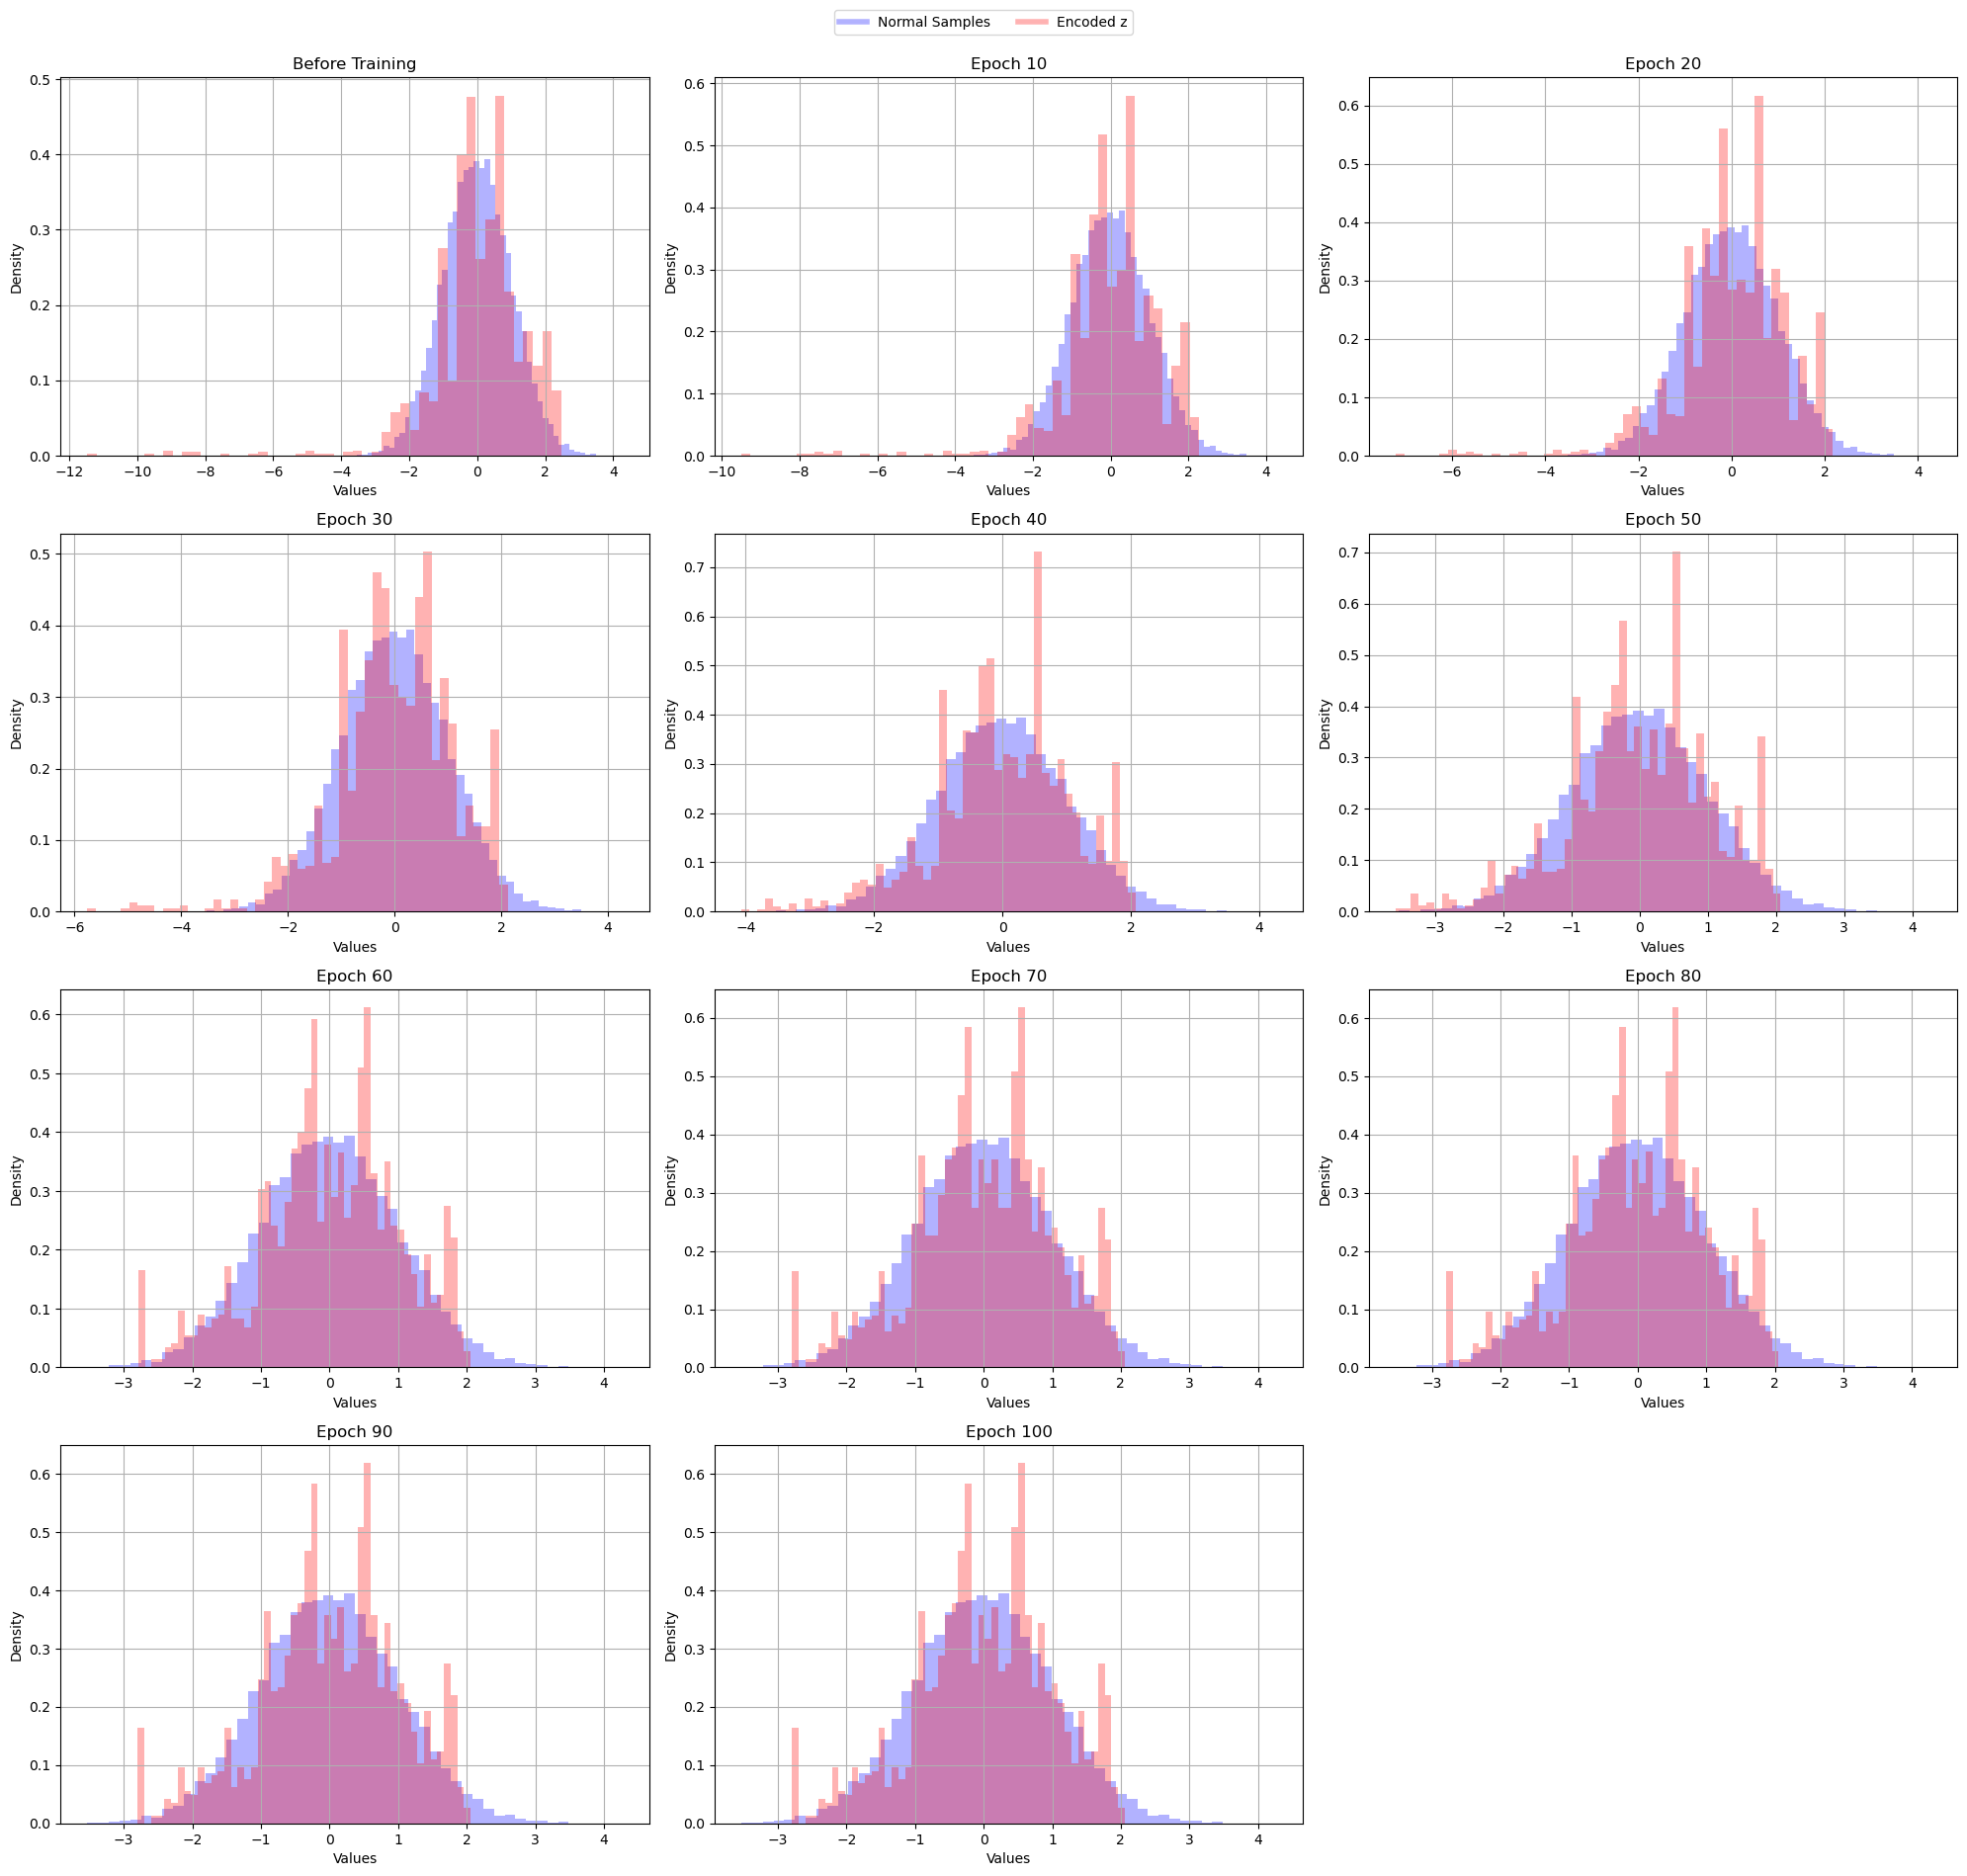

In [37]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=test_data, figsize=(20,20),
                model_params_list=epoch_wise_param_list,
                num_coeffs=10,print_model_params=0, plot_freq=10) # 40 more (30 below+40 x3 below + 40  more= 70+40+40 + 40=110+40 +40=150+40=190)